In [12]:
# increase the cell width 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; } </style>"))   

### convert hotpotqa to squard format

According to Longformer: use the following input format with special tokens:  “[CLS] [q] question [/q] [p] sent1,1 [s] sent1,2 [s] ... [p] sent2,1 [s] sent2,2 [s] ...” 
where [s] and [p] are special tokens representing sentences and paragraphs. The special tokens were added to the RoBERTa vocabulary and randomly initialized before task finetuning.

In [1]:
# helper functions to convert hotpotqa to squard format modified from  https://github.com/chiayewken/bert-qa/blob/master/run_hotpot.py

import tqdm

def create_example_dict(context, answers, id, is_impossible, question, is_sup_fact, is_supporting_para):
    return {
        "context": context,
        "qas": [                        # each context corresponds to only one qa in hotpotqa
            {
                "answers": answers,
                "id": id,
                "is_impossible": is_impossible,
                "question": question,
                "is_sup_fact": is_sup_fact,
                "is_supporting_para": is_supporting_para
            }
        ],
    }


def create_para_dict(example_dicts):
    if type(example_dicts) == dict:
        example_dicts = [example_dicts]   # each paragraph corresponds to only one [context, qas] in hotpotqa
    return {"paragraphs": example_dicts}   

In [2]:
import sys
sys.path.insert(-1, '/xdisk/msurdeanu/fanluo/miniconda3/lib/python3.7/site-packages')

from prettytable import PrettyTable
import spacy   
import en_core_web_lg                         
nlp = en_core_web_lg.load()
#!python -m pip install pytextrank
# Fan: changed pytextrank.py so that p.text are the joint of lemma tokens with pos_ in kept_pos, and maintain the order when join 
import pytextrank
tr = pytextrank.TextRank()     
nlp.add_pipe(tr.PipelineComponent, name='textrank', last=True)
import neuralcoref
neuralcoref.add_to_pipe(nlp)


In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

#!conda install networkx --yes
import networkx as nx
from itertools import chain

 
def create_para_graph(paras_phrases):
    G = nx.Graph()    
    top_para_phrases = []    # node id of the first (top ranked) phrases from each para 
    for para_phrases in paras_phrases: 
        # complet graph for each para
        para_G = nx.complete_graph(range(G.number_of_nodes(), G.number_of_nodes() + len(para_phrases))) 
        G = nx.compose(G, para_G)
        # add an edge between the top ranked phrases from each para to bridge paras
        for top_para_phrase in top_para_phrases:
            G.add_edge(G.number_of_nodes(), top_para_phrase)
            top_para_phrases.append(G.number_of_nodes())
    
    # Draw
    fig = plt.figure(figsize=(25, 25))
    pos = nx.random_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=5, linewidths=5,
            node_size=500, node_color='orange', alpha=0.9,
            # faltten embedded list and create a dict
            labels= {i:phrase for i, phrase in enumerate(chain.from_iterable(paras_phrases))}                           
            )     

In [33]:
import re
def convert_hotpot_to_squad_format(json_dict, gold_paras_only=False):
    
    """function to convert hotpotqa to squard format.


    Note: A context corresponds to several qas in SQuard. In hotpotqa, one question corresponds to several paragraphs as context. 
          "paragraphs" means different: each paragraph in SQuard contains a context and a list of qas; while 10 paragraphs in hotpotqa concatenated into a context for one question.

    Args:
        json_dict: The original data load from hotpotqa file.
        gold_paras_only: when is true, only use the 2 paragraphs that contain the gold supporting facts; if false, use all the 10 paragraphs
 

    Returns:
        new_dict: The converted dict of hotpotqa dataset, use it as a dict would load from SQuAD json file
                  usage: input_data = new_dict["data"]   https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_squad.py#L230

    """
    noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
    new_dict = {"data": []} 
    
    for example in json_dict: 

        support_para = set(
            para_title for para_title, _ in example["supporting_facts"]
        )
        sp_set = set(list(map(tuple, example['supporting_facts'])))
        
        raw_contexts = example["context"]
#         if gold_paras_only: 
#             raw_contexts = [lst for lst in raw_contexts if lst[0] in support_para]    

        question_doc = nlp(example["question"])
        question = question_doc._.coref_resolved
        question_phrases = question_doc._.phrases
            
        contexts = [" <s> ".join(lst[1]) for lst in raw_contexts]    # extra space is fine, which would be ignored latter. 
                                                                     # most sentences has already have heading space, there are several no heading space 
        coref_resolved_paras = []                                    # a list of 10 paragragh text, with correferences resolved
        paras_phrases = []                                           # phrases of all 10 paragraghs
        para_docs = list(nlp.pipe(contexts))                         # get the doc after concatenation of sentences in each para to allow  merging nodes with pytextrank and resolve correference. This adds work to figure out how many phrases from each sentence, for adding edge between phrases from the same sentence.  
         
        for i, para_doc in enumerate(para_docs): 
            coref_resolved_paras.append(para_doc._.coref_resolved)
            para_phrases = para_doc._.phrases
            paras_phrases.append(para_phrases)       
            
            sent_phrases = {}           # phrases from each sentence
  
                    

        print(question)
        print(question_phrases)      
        print(*(paras_phrases))   
        print(coref_resolved_paras)   
        print(contexts)   
        
        create_para_graph(paras_phrases, num_sentences)
        
        
        assert(1==2)
            
        context = " <p> " + " <p> ".join(coref_resolved_paras)
        
        is_supporting_para = []  # a boolean list with 10 True/False elements, one for each paragraph
        is_sup_fact = []         # a boolean list with True/False elements, one for each context sentence
        for para_title, para_lines in raw_contexts:
            is_supporting_para.append(para_title in support_para)   
            for sent_id, sent in enumerate(para_lines):
                is_sup_fact.append( (para_title, sent_id) in sp_set )


        answer = example["answer"].strip() 
        if answer.lower() == 'yes':
            answers = [{"answer_start": -1, "answer_end": -1, "text": answer}] 
        elif answer.lower() == 'no':
            answers = [{"answer_start": -2, "answer_end": -2, "text": answer}] 
        else:
            answers = []          # keep all the occurences of answer in the context
            for m in re.finditer(re.escape(answer), context):    
                answer_start, answer_end = m.span() 
                answers.append({"answer_start": answer_start, "answer_end": answer_end, "text": answer})
             
        if(len(answers) > 0): 
            new_dict["data"].append(
                create_para_dict(
                    create_example_dict(
                        context=context,
                        answers=answers,
                        id = example["_id"],
                        is_impossible=(answers == []),
                        question=question,
                        is_sup_fact = is_sup_fact,
                        is_supporting_para = is_supporting_para 
                    )
                )
            ) 
    return new_dict

Which magazine was started first Arthur's Magazine or First for Women?
[First, Arthur Magazine, woman, magazine, Arthur]
[music relate news, regional music, New medium, Radio City, most city, New Delhi, India first private FM radio station, Visakhapatnam October, Abraham Thomas, regional song, other music relate feature, Hyderabad, megahertz, Hindi, Visakhapatnam, song, first, India, English, planetradiocity.com, music portal, Radio station, March, video, Lucknow, May, Mumbai, Chennai, Bengaluru, ceo, October, July, company, mix, launch, ] [Albanian National Team, Albania, Balkan Cup, competition, FSHF, first, June, Albanian Football Federation, first international match, Balkan Cup tournament, Albanian Football Federation FSHF, 12–16 June convention, FIFA, pressure, UEFA, football, found member, Yugoslavia, team, team registration, year, duel, ] [eld sibling Jamie, Ready Set go, Warner Bros., sibling, Graham Sierota, Cool Kids, american corporate indie pop band, talk Dreams, ARIA, Noa

AssertionError: 

<Figure size 1800x1800 with 0 Axes>

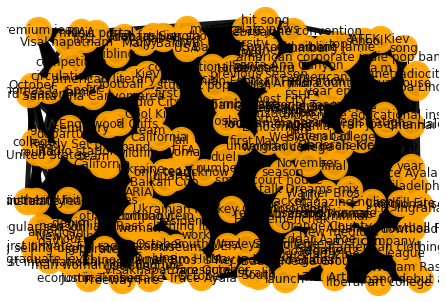

In [34]:
# debug: check whether convert_hotpot_to_squad_format() works
import os
os.chdir('/xdisk/msurdeanu/fanluo/hotpotQA/')
#!cat /xdisk/msurdeanu/fanluo/hotpotQA/hotpot_train_v1.1.json | ../jq-linux64 -c '.[0:16]' > small.json
#!cat /xdisk/msurdeanu/fanluo/hotpotQA/hotpot_train_v1.1.json | ../jq-linux64 -c '.[17:30]' > small_dev.json
#!cat /xdisk/msurdeanu/fanluo/hotpotQA/hotpot_train_v1.1.json | ../jq-linux64 -c '.[31:50]' > sample.json

import json
with open("small.json", "r", encoding='utf-8') as f:  
    json_dict = convert_hotpot_to_squad_format(json.load(f))['data']
    print(json.dumps(json_dict[0], indent=2))

### longfomer's fine-tuning


- For answer span extraction we use BERT’s QA model with addition of a question type (yes/no/span) classification head over the first special token ([CLS]).

- For evidence extraction we apply 2 layer feedforward networks on top of the representations corresponding to sentence and paragraph tokens to get the corresponding evidence prediction scores and use binary cross entropy loss to train the model.

- We combine span, question classification, sentence, and paragraphs losses and train the model in a multitask way using linear combination of losses.


In [5]:
### Section2: This is modified from longfomer's fine-tuning with triviaqa.py from https://github.com/allenai/longformer/blob/master/scripts/triviaqa.py
# !conda install transformers --yes
# !conda install cudatoolkit=10.0 --yes
# !python -m pip install git+https://github.com/allenai/longformer.git
####requirements.txt:torch>=1.2.0, transformers>=3.0.2, tensorboardX, pytorch-lightning==0.6.0, test-tube==0.7.5
# !conda install -c conda-forge regex --force-reinstall --yes
# !conda install pytorch-lightning -c conda-forge
# !pip install jdc 
# !pip install test-tube 
# !conda install ipywidgets --yes
# !conda update --force conda --yes  
# !jupyter nbextension enable --py widgetsnbextension 
# !conda install jupyter --yes

# need to run this every time start this notebook, to add python3.7/site-packages to sys.pat, in order to import ipywidgets, which is used when RobertaTokenizer.from_pretrained('roberta-base') 
import sys
sys.path.insert(-1, '/xdisk/msurdeanu/fanluo/miniconda3/lib/python3.7/site-packages')

import os
from collections import defaultdict
import json
import string
import random
import numpy as np
import torch
from torch.optim.lr_scheduler import LambdaLR

from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer 

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.overrides.data_parallel import LightningDistributedDataParallel
from pytorch_lightning.logging import TestTubeLogger    # sometimes pytorch_lightning.loggers works instead


from longformer.longformer import Longformer
from longformer.sliding_chunks import pad_to_window_size
import jdc
from more_itertools import locate
from collections import Counter


In [6]:
print(pl.__file__)

/xdisk/msurdeanu/fanluo/miniconda3/envs/hotpotqa/lib/python3.6/site-packages/pytorch_lightning/__init__.py


#### class hotpotqaDataset

##### \_\_init\_\_, \_\_getitem\_\_ and \_\_len\_\_ 

In [7]:
class hotpotqaDataset(Dataset):
    """
    Largely based on
    https://github.com/allenai/allennlp/blob/master/allennlp/data/dataset_readers/reading_comprehension/triviaqa.py
    and
    https://github.com/huggingface/transformers/blob/master/examples/run_squad.py
    """
    
    
    def __init__(self, file_path, tokenizer, max_seq_len, max_doc_len, doc_stride,
                 max_num_answers, ignore_seq_with_no_answers, max_question_len):
        assert os.path.isfile(file_path)
        self.file_path = file_path
        with open(self.file_path, "r", encoding='utf-8') as f:
            print(f'reading file: {self.file_path}')
            self.data_json = convert_hotpot_to_squad_format(json.load(f))['data']
#             print(self.data_json[0])
        
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.max_doc_len = max_doc_len
        self.doc_stride = doc_stride
        self.max_num_answers = max_num_answers
        self.ignore_seq_with_no_answers = ignore_seq_with_no_answers
        self.max_question_len = max_question_len

        print(tokenizer.all_special_tokens)
        print(tokenizer.all_special_ids)
    
        # A mapping from qid to an int, which can be synched across gpus using `torch.distributed`
        if 'train' not in self.file_path:  # only for the evaluation set 
            self.val_qid_string_to_int_map =  \
                {
                    entry["paragraphs"][0]['qas'][0]['id']: index
                    for index, entry in enumerate(self.data_json)
                }
        else:
            self.val_qid_string_to_int_map = None
            
            
    def __len__(self):
        return len(self.data_json)

    def __getitem__(self, idx):
        entry = self.data_json[idx]
        tensors_list = self.one_example_to_tensors(entry, idx)
        assert len(tensors_list) == 1
        return tensors_list[0]
    

##### one_example_to_tensors

In [8]:
    %%add_to hotpotqaDataset
    def one_example_to_tensors(self, example, idx):
        def is_whitespace(c):
            if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
                return True
            return False
        tensors_list = []
        for paragraph in example["paragraphs"]:  # example["paragraphs"] only contains one paragraph in hotpotqa
            paragraph_text = paragraph["context"]
            doc_tokens = []
            char_to_word_offset = []
            prev_is_whitespace = True
            for c in paragraph_text:
                if is_whitespace(c):
                    prev_is_whitespace = True
                else:
                    if prev_is_whitespace:
                        doc_tokens.append(c) # add a new token
                    else:
                        doc_tokens[-1] += c  # append the character to the last token
                    prev_is_whitespace = False
                char_to_word_offset.append(len(doc_tokens) - 1)

            for qa in paragraph["qas"]:
                question_text = qa["question"]
#                 print("question text: ", question_text)  
                sp_sent = qa["is_sup_fact"]
                sp_para = qa["is_supporting_para"]
                start_position = None
                end_position = None
                orig_answer_text = None
                
                p_list = list(locate(doc_tokens , lambda x: x == "<p>")) 
                assert(len(p_list) == len(sp_para))
                s_list = list(locate(doc_tokens , lambda x: x == "<s>"))
#                 
#                 if(len(s_list) + len(p_list) != len(sp_sent)):
#                     print("len(s_list):", len(s_list))
#                     print("len(p_list):", len(p_list))
#                     print("len(sp_sent):", len(sp_sent))
#                     print("sp_sent", sp_sent)
#                     print("paragraph_text", paragraph_text)
#                     print("doc_tokens", doc_tokens)
                assert(len(s_list) + len(p_list) == len(sp_sent) )
                
                # keep all answers in the document, not just the first matched answer. It also added the list of textual answers to make evaluation easy.
                answer_spans = []
                for answer in qa["answers"]:
                    orig_answer_text = answer["text"]
#                     print("orig_answer_text: ", orig_answer_text)
                    answer_start = answer["answer_start"]
                    answer_end = answer["answer_end"]  
                    if(answer_start >= 0 and answer_end > 0):
                        try:
                            start_word_position = char_to_word_offset[answer_start]
                            end_word_position = char_to_word_offset[answer_end-1]
#                             print("answer by start_word_position and end_word_position: ", doc_tokens[start_word_position: end_word_position+1])
                        except:
                            print(f'error: Reading example {idx} failed')
                            start_word_position = -3
                            end_word_position = -3
                            
                    else:
                        start_word_position = answer["answer_start"]
                        end_word_position = answer["answer_end"]
                    answer_spans.append({'start': start_word_position, 'end': end_word_position})

                    
                # ===== Given an example, convert it into tensors  =============
                query_tokens = self.tokenizer.tokenize(question_text)
                query_tokens = query_tokens[:self.max_question_len]
                tok_to_orig_index = []
                orig_to_tok_index = []
                all_doc_tokens = []
                
                # each original token in the context is tokenized to multiple sub_tokens
                for (i, token) in enumerate(doc_tokens):
                    orig_to_tok_index.append(len(all_doc_tokens))
                    # hack: the line below should have been `self.tokenizer.tokenize(token')`
                    # but roberta tokenizer uses a different subword if the token is the beginning of the string
                    # or in the middle. So for all tokens other than the first, simulate that it is not the first
                    # token by prepending a period before tokenizing, then dropping the period afterwards
                    sub_tokens = self.tokenizer.tokenize(f'. {token}')[1:] if i > 0 else self.tokenizer.tokenize(token)
                    for sub_token in sub_tokens:
                        tok_to_orig_index.append(i)
                        all_doc_tokens.append(sub_token)
                
                # all sub tokens, truncate up to limit
                all_doc_tokens = all_doc_tokens[:self.max_doc_len-3]

                # The -3 accounts for [CLS], [q], [/q]  
                max_tokens_per_doc_slice = self.max_seq_len - len(query_tokens) - 3
                assert max_tokens_per_doc_slice > 0
                if self.doc_stride < 0:                           # default
                    # negative doc_stride indicates no sliding window, but using first slice
                    self.doc_stride = -100 * len(all_doc_tokens)  # large -negtive value for the next loop to execute once
                
                # inputs to the model
                input_ids_list = []
                input_mask_list = []
                segment_ids_list = []
                start_positions_list = []
                end_positions_list = []
                q_type_list = []
                sp_sent_list =  [1 if ss else 0 for ss in sp_sent]
                sp_para_list = [1 if sp else 0 for sp in sp_para]
                
                for slice_start in range(0, len(all_doc_tokens), max_tokens_per_doc_slice - self.doc_stride):    # execute once by default
                    slice_end = min(slice_start + max_tokens_per_doc_slice, len(all_doc_tokens))

                    doc_slice_tokens = all_doc_tokens[slice_start:slice_end]
                    tokens = ["<cls>"] + ["<q>"] + query_tokens + ["</q>"] + doc_slice_tokens   
#                     print("tokens: ", tokens)
                    segment_ids = [0] * (len(query_tokens) + 3) + [1] *  len(doc_slice_tokens) 
                    assert len(segment_ids) == len(tokens)

                    input_ids = self.tokenizer.convert_tokens_to_ids(tokens)   
                    input_mask = [1] * len(input_ids)

                    if self.doc_stride >= 0:  # no need to pad if document is not strided
                        # Zero-pad up to the sequence length.
                        padding_len = self.max_seq_len - len(input_ids)
                        input_ids.extend([self.tokenizer.pad_token_id] * padding_len)
                        input_mask.extend([0] * padding_len)
                        segment_ids.extend([0] * padding_len)

                        assert len(input_ids) == self.max_seq_len
                        assert len(input_mask) == self.max_seq_len
                        assert len(segment_ids) == self.max_seq_len

                    # ===== answer positions tensors  ============
                    doc_offset = len(query_tokens) + 3 - slice_start  # where context starts
                    start_positions = []
                    end_positions = []
                    q_type = None
                    assert(len(answer_spans) > 0)
                    for answer_span in answer_spans:
                        start_position = answer_span['start']   # reletive to context
                        end_position = answer_span['end']
                        if(start_position >= 0):
                            tok_start_position_in_doc = orig_to_tok_index[start_position]  # sub_tokens postion reletive to context
                            not_end_of_doc = int(end_position + 1 < len(orig_to_tok_index))
                            tok_end_position_in_doc = orig_to_tok_index[end_position + not_end_of_doc] - not_end_of_doc
                            if tok_start_position_in_doc < slice_start or tok_end_position_in_doc > slice_end:
                                assert("this answer is outside the current slice")   # only has one slice with the large negative doc_stride
                                continue                                
                            start_positions.append(tok_start_position_in_doc + doc_offset)   # sub_tokens postion reletive to begining of all the tokens, including query sub tokens  
                            end_positions.append(tok_end_position_in_doc + doc_offset)
#                             print("answer by start_positions and end_positions: ", tokens[tok_start_position_in_doc + doc_offset: tok_end_position_in_doc + doc_offset+1])
                            if(q_type != None and q_type != 0):
                                assert("inconsistance q_type")
                            q_type = 0
                
                        elif(start_position == -1):
                            if(q_type != None and q_type != 1):
                                assert("inconsistance q_type")
                            q_type = 1
                            start_positions.append(-1)  # -1 is the IGNORE_INDEX, will be ignored
                            end_positions.append(-1)     
                        elif(start_position == -2):
                            if(q_type != None and q_type != 2):
                                assert("inconsistance q_type")
                            q_type = 2
                            start_positions.append(-1)
                            end_positions.append(-1)     
                        else:
                            assert("unknown start_positions")
                            continue
                    assert len(start_positions) == len(end_positions)
                    
                    
                    if self.ignore_seq_with_no_answers and len(start_positions) == 0:
                        continue

                    # answers from start_positions and end_positions if > self.max_num_answers
                    start_positions = start_positions[:self.max_num_answers]
                    end_positions = end_positions[:self.max_num_answers]

                    # -1 padding up to self.max_num_answers
                    padding_len = self.max_num_answers - len(start_positions)
                    start_positions.extend([-1] * padding_len)
                    end_positions.extend([-1] * padding_len)

                    # replace duplicate start/end positions with `-1` because duplicates can result into -ve loss values
                    found_start_positions = set()
                    found_end_positions = set()
                    for i, (start_position, end_position) in enumerate(zip(start_positions, end_positions)):
                        if start_position in found_start_positions:
                            start_positions[i] = -1
                        if end_position in found_end_positions:
                            end_positions[i] = -1
                        found_start_positions.add(start_position)
                        found_end_positions.add(end_position)

                    input_ids_list.append(input_ids)
                    input_mask_list.append(input_mask)
                    segment_ids_list.append(segment_ids)
                    start_positions_list.append(start_positions)
                    end_positions_list.append(end_positions)
                    q_type_list.append(q_type)
                if (input_ids_list is None):
                    print("input_ids_list is None")
                if (input_mask_list is None):
                    print("input_mask_list is None")
                if (segment_ids_list is None):
                    print("segment_ids_list is None")
                if (start_positions_list is None):
                    print("start_positions_list is None")
                if (end_positions_list is None):
                    print("end_positions_list is None")
                if (q_type_list is None):
                    print("q_type_list is None")
                if (sp_sent_list is None):
                    print("sp_sent_list is None")
                if (sp_para_list is None):
                    print("sp_para_list is None")
                if (qa['id'] is None):
                    print("qa['id'] is None")
                tensors_list.append((torch.tensor(input_ids_list), torch.tensor(input_mask_list), torch.tensor(segment_ids_list),
                                     torch.tensor(start_positions_list), torch.tensor(end_positions_list), torch.tensor(q_type_list),
                                      torch.tensor([sp_sent_list]),  torch.tensor([sp_para_list]),
                                     qa['id']))    
#                 tensors_list.append((doc_tokens))
        return tensors_list

##### collate_one_doc_and_lists

In [9]:
    %%add_to hotpotqaDataset
    @staticmethod
    def collate_one_doc_and_lists(batch):
        num_metadata_fields = 1  # qids  
        fields = [x for x in zip(*batch)]
        stacked_fields = [torch.stack(field) for field in fields[:-num_metadata_fields]]  # don't stack metadata fields
        stacked_fields.extend(fields[-num_metadata_fields:])  # add them as lists not torch tensors

        # always use batch_size=1 where each batch is one document
        # will use grad_accum to increase effective batch size
        assert len(batch) == 1
        fields_with_batch_size_one = [f[0] for f in stacked_fields]
        return fields_with_batch_size_one

##### class info

In [10]:
dir(hotpotqaDataset)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'collate_one_doc_and_lists',
 'one_example_to_tensors']

In [11]:
from inspect import getmembers
getmembers(hotpotqaDataset)

[('__add__', <function torch.utils.data.dataset.Dataset.__add__(self, other)>),
 ('__class__', type),
 ('__delattr__', <slot wrapper '__delattr__' of 'object' objects>),
 ('__dict__',
  mappingproxy({'__module__': '__main__',
                '__doc__': '\n    Largely based on\n    https://github.com/allenai/allennlp/blob/master/allennlp/data/dataset_readers/reading_comprehension/triviaqa.py\n    and\n    https://github.com/huggingface/transformers/blob/master/examples/run_squad.py\n    ',
                '__init__': <function __main__.hotpotqaDataset.__init__(self, file_path, tokenizer, max_seq_len, max_doc_len, doc_stride, max_num_answers, ignore_seq_with_no_answers, max_question_len)>,
                '__len__': <function __main__.hotpotqaDataset.__len__(self)>,
                '__getitem__': <function __main__.hotpotqaDataset.__getitem__(self, idx)>,
                'one_example_to_tensors': <function __main__.one_example_to_tensors(self, example, idx)>,
                'collate_one

In [12]:
from inspect import isfunction
functions_list = [o for o in getmembers(hotpotqaDataset) if isfunction(o[1])]
functions_list

[('__add__', <function torch.utils.data.dataset.Dataset.__add__(self, other)>),
 ('__getitem__', <function __main__.hotpotqaDataset.__getitem__(self, idx)>),
 ('__init__',
  <function __main__.hotpotqaDataset.__init__(self, file_path, tokenizer, max_seq_len, max_doc_len, doc_stride, max_num_answers, ignore_seq_with_no_answers, max_question_len)>),
 ('__len__', <function __main__.hotpotqaDataset.__len__(self)>),
 ('collate_one_doc_and_lists',
  <function __main__.collate_one_doc_and_lists(batch)>),
 ('one_example_to_tensors',
  <function __main__.one_example_to_tensors(self, example, idx)>)]

In [13]:
import inspect
inspect.getmro(hotpotqaDataset)  # a hierarchy of classes 

(__main__.hotpotqaDataset, torch.utils.data.dataset.Dataset, object)

In [14]:
inspect.getfullargspec(hotpotqaDataset.one_example_to_tensors)

FullArgSpec(args=['self', 'example', 'idx'], varargs=None, varkw=None, defaults=None, kwonlyargs=[], kwonlydefaults=None, annotations={})

In [15]:
help(hotpotqaDataset)

Help on class hotpotqaDataset in module __main__:

class hotpotqaDataset(torch.utils.data.dataset.Dataset)
 |  Largely based on
 |  https://github.com/allenai/allennlp/blob/master/allennlp/data/dataset_readers/reading_comprehension/triviaqa.py
 |  and
 |  https://github.com/huggingface/transformers/blob/master/examples/run_squad.py
 |  
 |  Method resolution order:
 |      hotpotqaDataset
 |      torch.utils.data.dataset.Dataset
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, idx)
 |  
 |  __init__(self, file_path, tokenizer, max_seq_len, max_doc_len, doc_stride, max_num_answers, ignore_seq_with_no_answers, max_question_len)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  one_example_to_tensors(self, example, idx)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  collate_one_doc_and_lists(batch)
 |  
 |  -----------------------

#### class hotpotqa

##### \_\_init\_\_,  forward, dataloaders

In [16]:
class hotpotqa(pl.LightningModule):
    def __init__(self, args):
        super(hotpotqa, self).__init__()
        self.args = args
        self.hparams = args

        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        num_new_tokens = self.tokenizer.add_special_tokens({"additional_special_tokens": ["<cls>", "<p>", "<q>", "</q>"]})
#         print(self.tokenizer.all_special_tokens)
        self.tokenizer.model_max_length = self.args.max_seq_len
        self.model = self.load_model()
        self.model.resize_token_embeddings(len(self.tokenizer))
        self.num_labels = 2
        self.qa_outputs = torch.nn.Linear(self.model.config.hidden_size, self.num_labels)
        
        self.dense_type = torch.nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        self.linear_type = torch.nn.Linear(self.model.config.hidden_size, 3)   #  question type (yes/no/span) classification 
        self.dense_sp_sent = torch.nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        self.linear_sp_sent = torch.nn.Linear(self.model.config.hidden_size, 1)    
        self.dense_sp_para = torch.nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        self.linear_sp_para = torch.nn.Linear(self.model.config.hidden_size, 1) 
        self.train_dataloader_object = self.val_dataloader_object  = None  # = self.test_dataloader_object = None
    
    def load_model(self):
#         model = Longformer.from_pretrained(self.args.model_path)
        model = Longformer.from_pretrained('longformer-base-4096')
        for layer in model.encoder.layer:
            layer.attention.self.attention_mode = self.args.attention_mode
            self.args.attention_window = layer.attention.self.attention_window

        print("Loaded model with config:")
        print(model.config)

        for p in model.parameters():
            p.requires_grad_(True)
        model.train()
        return model

#%%add_to hotpotqa    # does not seems to work for the @pl.data_loader decorator, missing which causes error "validation_step() takes 3 positional arguments but 4 were given"    
###################################################### dataloaders ########################################################### 
    @pl.data_loader
    def train_dataloader(self):
        if self.train_dataloader_object is not None:
            return self.train_dataloader_object
        dataset = hotpotqaDataset(file_path=self.args.train_dataset, tokenizer=self.tokenizer,
                                  max_seq_len=self.args.max_seq_len, max_doc_len=self.args.max_doc_len,
                                  doc_stride=self.args.doc_stride,
                                  max_num_answers=self.args.max_num_answers,
                                  max_question_len=self.args.max_question_len,
                                  ignore_seq_with_no_answers=self.args.ignore_seq_with_no_answers)
 
        dl = DataLoader(dataset, batch_size=1, shuffle=False,   # set shuffle=False, otherwise it will sample a different subset of data every epoch with train_percent_check
                        num_workers=self.args.num_workers,  
                        collate_fn=hotpotqaDataset.collate_one_doc_and_lists)

        self.train_dataloader_object = dl
        return self.train_dataloader_object

    @pl.data_loader
    def val_dataloader(self):
        if self.val_dataloader_object is not None:
            return self.val_dataloader_object
        dataset = hotpotqaDataset(file_path=self.args.dev_dataset, tokenizer=self.tokenizer,
                                  max_seq_len=self.args.max_seq_len, max_doc_len=self.args.max_doc_len,
                                  doc_stride=self.args.doc_stride,
                                  max_num_answers=self.args.max_num_answers,
                                  max_question_len=self.args.max_question_len,
                                  ignore_seq_with_no_answers=False)  # evaluation data should keep all examples 
        dl = DataLoader(dataset, batch_size=1, shuffle=False,
                        num_workers=self.args.num_workers, 
                        collate_fn=hotpotqaDataset.collate_one_doc_and_lists)
        self.val_dataloader_object = dl
        return self.val_dataloader_object

    # @pl.data_loader
    # def test_dataloader(self):
    #     if self.test_dataloader_object is not None:
    #         return self.test_dataloader_object
    #     dataset = hotpotqaDataset(file_path=self.args.dev_dataset, tokenizer=self.tokenizer,
    #                               max_seq_len=self.args.max_seq_len, max_doc_len=self.args.max_doc_len,
    #                               doc_stride=self.args.doc_stride,
    #                               max_num_answers=self.args.max_num_answers,
    #                               max_question_len=self.args.max_question_len,
    #                               ignore_seq_with_no_answers=False)  # evaluation data should keep all examples

    #     dl = DataLoader(dataset, batch_size=1, shuffle=False,
    #                     num_workers=self.args.num_workers, sampler=None,
    #                     collate_fn=hotpotqaDataset.collate_one_doc_and_lists)
    #     self.test_dataloader_object = dl
    #     return self.test_dataloader_object

#%%add_to hotpotqa  
    def forward(self, input_ids, attention_mask, segment_ids, start_positions, end_positions, q_type, sp_sent, sp_para):
#         print("input_ids: " + str(input_ids)) 
#         print("attention_mask: " + str(attention_mask)) 
#         print("segment_ids: " + str(segment_ids)) 
#         print("start_positions: " + str(start_positions)) 
#         print("end_positions: " + str(end_positions)) 
        print("q_type: " + str(q_type))
#         print("sp_sent: " + str(sp_sent)) 
#         print("sp_para: " + str(sp_para)) 
        print("size of input_ids: " + str(input_ids.size())) 
        print("size of attention_mask: " + str(attention_mask.size()))
        print("size of segment_ids: " + str(segment_ids.size()))
        print("size of start_positions: " + str(start_positions.size()))
        print("size of end_positions:" + str(end_positions.size()))
        print("size of q_type:" + str(q_type.size()))
        print("size of sp_sent: " + str(sp_sent.size()))
        print("size of sp_para: " + str(sp_para.size())) 
#         if(input_ids.size(0) > 1):
#             assert("multi rows per document")
        # Each batch is one document, and each row of the batch is a chunck of the document.    ????
        # Make sure all rows have the same question length.
        
#         size of input_ids: torch.Size([1, 1495])
#         size of attention_mask: torch.Size([1, 1495])
#         size of segment_ids: torch.Size([1, 1495])
#         size of start_positions: torch.Size([1, 64])   # multiple occurences of the same answer string, -1 padding up to self.max_num_answers
#         size of end_positions: torch.Size([1, 64])
#         size of q_type: torch.Size([1, 1])
#         size of sp_sent: torch.Size([1, 40])           # number of sentences in context
#         size of sp_para: torch.Size([1, 10])
#         print("input tokens: ", self.tokenizer.convert_ids_to_tokens(input_ids[0].tolist()) )
#         print("sp_para: " + str(sp_para)) 
#         print("sp_sent: " + str(sp_sent)) 
#         print("sp_sent_index: " + str(torch.where(sp_sent.squeeze())[0].tolist()))
        # sp_para: tensor([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]], device='cuda:0')
        # sp_sent: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        #          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]], device='cuda:0')
        # sp_sent_index: [14, 17, 18, 35, 36]

        # local attention everywhere
        attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=input_ids.device)
        
        # global attention for the cls and all question tokens
        question_end_index = self._get_special_index(input_ids, ["</q>"])
#         if(question_end_index.size(0) == 1):
#             attention_mask[:,:question_end_index.item()] = 2  
#         else:
        attention_mask[:,:question_end_index[0].item()] = 2  # from <cls> until </q>
#             print("more than 1 <q> in: ", self.tokenizer.convert_ids_to_tokens(input_ids[0].tolist()) )
        
        # global attention for the sentence and paragraph special tokens  
        sent_indexes = self._get_special_index(input_ids, ["<p>", "<s>"])
        attention_mask[:, sent_indexes] = 2
#         p_index = self._get_special_index(input_ids, ["<p>"])
#         print("size of p_index: " + str(p_index.size()))
#         attention_mask[:, p_index] = 2 
#         s_index = self._get_special_index(input_ids, ["<s>"])
#         print("size of s_index: " + str(s_index.size()))
#         attention_mask[:, s_index] = 2
        
#         print("p_index:", p_index) 
#         print("attention_mask: ", attention_mask)
        

        # sliding_chunks implemenation of selfattention requires that seqlen is multiple of window size
        input_ids, attention_mask = pad_to_window_size(
            input_ids, attention_mask, self.args.attention_window, self.tokenizer.pad_token_id)

        sequence_output = self.model(
                input_ids,
                attention_mask=attention_mask)[0]
        print("size of sequence_output: " + str(sequence_output.size()))

        # The pretrained hotpotqa model wasn't trained with padding, so remove padding tokens
        # before computing loss and decoding.
        padding_len = input_ids[0].eq(self.tokenizer.pad_token_id).sum()
        if padding_len > 0:
            sequence_output = sequence_output[:, :-padding_len]
        print("size of sequence_output after removing padding: " + str(sequence_output.size()))
              
        
        ###################################### layers on top of sequence_output ##################################
        

        ### 1. answer start and end positions classification ###   
        logits = self.qa_outputs(sequence_output)
#         print("size of logits: " + str(logits.size())) 
        start_logits, end_logits = logits.split(1, dim=-1)
#         print("size of start_logits: " + str(start_logits.size())) 
        start_logits = start_logits.squeeze(-1)
#         print("size of start_logits after squeeze: " + str(start_logits.size())) 
        end_logits = end_logits.squeeze(-1)
 
        ### 2. type classification, similar as class LongformerClassificationHead(nn.Module) https://huggingface.co/transformers/_modules/transformers/modeling_longformer.html#LongformerForSequenceClassification.forward ### 
#         print("size of sequence_output[:,0]: " + str(sequence_output[:,0].size()))
        type_logits = self.linear_type(sequence_output[:,0])
        print("size of type_logits: " + str(type_logits.size()))
        
        ### 3. supporting paragraph classification ### 
        p_index = self._get_special_index(input_ids, ["<p>"])
        print("size of p_index: " + str(p_index.size()))
        sp_para_output = sequence_output[:,p_index,:]
        print("size of sp_para_output: " + str(sp_para_output.size()))      
        sp_para_output_t = self.linear_sp_para(sp_para_output)
#         print("size of sp_para_output_t: " + str(sp_para_output_t.size()))  

         # linear_sp_sent generates a single score for each sentence, instead of 2 scores for yes and no. 	
        # Argument the score with additional score=0. The same way did in the HOTPOTqa paper
        sp_para_output_aux = torch.zeros(sp_para_output_t.shape, dtype=torch.float, device=sp_para_output_t.device) 
        predict_support_para = torch.cat([sp_para_output_aux, sp_para_output_t], dim=-1).contiguous() 
 
        ### 4. supporting fact classification ###     
        # the first sentence in a paragraph is leading by <p>, other sentences are leading by <s>
        
#         sent_indexes = torch.sort(torch.cat((s_index, p_index)))[0] # torch.sort returns a 'torch.return_types.sort' object has 2 items: values, indices
#         print("size of sent_indexes: " + str(sent_indexes.size()))
        print("sent_indexes: ", sent_indexes)
        sp_sent_output = sequence_output[:,sent_indexes,:]
#         print("size of sp_sent_output: " + str(sp_sent_output.size()))      
        sp_sent_output_t = self.linear_sp_sent(sp_sent_output)
#         print("size of sp_sent_output_t: " + str(sp_sent_output_t.size()))       
        sp_sent_output_aux = torch.zeros(sp_sent_output_t.shape, dtype=torch.float, device=sp_sent_output_t.device) 
        predict_support_sent = torch.cat([sp_sent_output_aux, sp_sent_output_t], dim=-1).contiguous() 
        
        outputs = (start_logits, end_logits, type_logits, sp_para_output_t, sp_sent_output_t)  
        #outputs = (torch.sigmoid(start_logits), torch.sigmoid(end_logits), torch.sigmoid(type_logits), torch.sigmoid(sp_para_output_t), torch.sigmoid(sp_sent_output_t))  
        answer_loss, type_loss, sp_para_loss, sp_sent_loss  = self.loss_computation(start_positions, end_positions, start_logits, end_logits, q_type, type_logits, sp_para, predict_support_para, sp_sent, predict_support_sent)
#         print("answer_loss: " + str(answer_loss))
#         print("type_loss: " + str(type_loss))
#         print("sp_para_loss: " + str(sp_para_loss))
#         print("sp_sent_loss: " + str(sp_sent_loss))
        outputs = (answer_loss, type_loss, sp_para_loss, sp_sent_loss,) + outputs    
        return outputs
    
    def loss_computation(self, start_positions, end_positions, start_logits, end_logits, q_type, type_logits, sp_para, predict_support_para, sp_sent, predict_support_sent):
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)

            if not self.args.regular_softmax_loss:
                # loss function suggested in section 2.2 here https://arxiv.org/pdf/1710.10723.pdf
                # NOTE: this returns sum of losses, not mean, so loss won't be normalized across different batch sizes
                # but batch size is always 1, so this is not a problem
                start_loss = self.or_softmax_cross_entropy_loss_one_doc(start_logits, start_positions, ignore_index=-1)
#                 print("start_positions: " + str(start_positions)) 
#                 print("start_loss: " + str(start_loss)) 
                end_loss = self.or_softmax_cross_entropy_loss_one_doc(end_logits, end_positions, ignore_index=-1)
#                 print("end_positions: " + str(end_positions)) 
#                 print("end_loss: " + str(end_loss)) 

#                 binary_loss = torch.nn.BCELoss()
# #                 print("sp_para_output_t.squeeze().type(): ", sp_para_output_t.squeeze().type())
# #                 print("sp_para.to(dtype=torch.half, device=sp_para.device).type(): ", sp_para.to(dtype=torch.half, device=sp_para.device).type())
#                 sp_para_loss = binary_loss(sp_para_output_t.squeeze(), sp_para.squeeze().to(dtype=torch.half, device=sp_para.device))
#                 sp_sent_loss = binary_loss(sp_sent_output_t.squeeze(), sp_sent.squeeze().to(dtype=torch.half, device=sp_sent.device))
                
#                 sp_para_loss = torch.tensor([0.0], device = predict_support_para.device )
# #                 print("predict_support_para.squeeze(): ", predict_support_para.squeeze())
# #                 print("sp_para.squeeze(): ", sp_para.squeeze())
#                 for para_predict, para_gold in zip(predict_support_para.squeeze(), sp_para.squeeze()):
# #                     print("para_predict.unsqueeze(0): ", para_predict.unsqueeze(0))
# #                     print(" para_gold.unsqueeze(0): ",  para_gold.unsqueeze(0))

                # only one example per batch
    
#                 print("size of sp_para_output_t: " + str(sp_para_output_t.size()))      
#                 print("size of sp_sent_output_t: " + str(sp_sent_output_t.size()))  

            else: 
                start_positions = start_positions[:, 0:1]   # only use the top1 start_position considering only one appearance of the answer string
                end_positions = end_positions[:, 0:1]
                start_loss = crossentropy(start_logits, start_positions[:, 0])
                end_loss = crossentropy(end_logits, end_positions[:, 0])
                

            crossentropy = torch.nn.CrossEntropyLoss(ignore_index=-1)
            type_loss_or_softmax_cross_entropy = self.or_softmax_cross_entropy_loss_one_doc(type_logits, q_type.unsqueeze(0), ignore_index=-1)
            type_loss = crossentropy(type_logits, q_type) 
            print("type_loss_or_softmax_cross_entropy: ", type_loss_or_softmax_cross_entropy)
            print("type_loss: ", type_loss) 
            
            crossentropy_average = torch.nn.CrossEntropyLoss(reduction = 'mean', ignore_index=-1)     
# #         print("predict_support_para.view(-1, 2).size()", predict_support_para.view(-1, 2).size())
# #         print("sp_para.view(-1).size()", sp_para.view(-1).size()) 
            sp_para_loss = crossentropy_average(predict_support_para.view(-1, 2), sp_para.view(-1))
            sp_sent_loss = crossentropy_average(predict_support_sent.view(-1, 2), sp_sent.view(-1))      
                
            answer_loss = (start_loss + end_loss) / 2 
        return answer_loss, type_loss, sp_para_loss, sp_sent_loss  


#     %%add_to hotpotqa    
    def _get_special_index(self, input_ids, special_tokens):
        assert(input_ids.size(0)==1) 
        mask = input_ids != input_ids # initilaize 
        for special_token in special_tokens:
            mask = torch.logical_or(mask, input_ids.eq(self.tokenizer.convert_tokens_to_ids(special_token))) 
#             print("mask: ", mask)
        token_indices = torch.nonzero(mask)    
         
        ### FOR DEBUG ###
        # input_ids = torch.tensor([[0.6, 0.0, 0.6, 0.0]]) 
        # token_indices =  torch.nonzero(input_ids == torch.tensor(0.6))
        return token_indices[:,1]    

    def or_softmax_cross_entropy_loss_one_doc(self, logits, target, ignore_index=-1, dim=-1):
        """loss function suggested in section 2.2 here https://arxiv.org/pdf/1710.10723.pdf"""
#         assert logits.ndim == 2
#         assert target.ndim == 2
#         assert logits.size(0) == target.size(0) 
        
        # with regular CrossEntropyLoss, the numerator is only one of the logits specified by the target, considing only one correct target 
        # here, the numerator is the sum of a few potential targets, where some of them is the correct answer, considing more correct targets

        # target are indexes of tokens, padded with ignore_index=-1
        # logits are scores (one for each label) for each token
#         print("or_softmax_cross_entropy_loss_one_doc" ) 
#         print("logits: " + str(logits)) 
#         print("size of logits: " + str(logits.size()))                    # torch.Size([1, 746]), 746 is number of all tokens 
#         print("size of target: " + str(target.size()))                    # torch.Size([1, 64]),  -1 padded
#         print("target: " + str(target)) 

        # compute a target mask
        target_mask = target == ignore_index
        # replaces ignore_index with 0, so `gather` will select logit at index 0 for the masked targets
        masked_target = target * (1 - target_mask.long())                 # replace all -1 in target with 0， tensor([[447,   0,   0,   0, ...]])
#         print("masked_target: " + str(masked_target))     
        # gather logits
        gathered_logits = logits.gather(dim=dim, index=masked_target)     # tensor([[0.4382, 0.2340, 0.2340, 0.2340 ... ]]), padding logits are all replaced by logits[0] 
#         print("size of gathered_logits: " + str(gathered_logits.size()))  # torch.Size([1, 64])
#         print("gathered_logits: " + str(gathered_logits)) 
        # Apply the mask to gathered_logits. Use a mask of -inf because exp(-inf) = 0
        gathered_logits[target_mask] = float('-inf')                      # padding logits are all replaced by -inf
#         print("gathered_logits after -inf: " + str(gathered_logits))      # tensor([[0.4382,   -inf,   -inf,   -inf,   -inf,...]])
        
        # each batch is one example
        gathered_logits = gathered_logits.view(1, -1)
        logits = logits.view(1, -1)
#         print("size of gathered_logits after view: " + str(gathered_logits.size()))  # torch.Size([1, 64])
#         print("size of logits after view: " + str(logits.size()))                    # torch.Size([1, 746])　　

        # numerator = log(sum(exp(gathered logits)))
        log_score = torch.logsumexp(gathered_logits, dim=dim, keepdim=False)
#         print("log_score: " + str(log_score)) 
        # denominator = log(sum(exp(logits)))
        log_norm = torch.logsumexp(logits, dim=dim, keepdim=False)
#         print("log_norm: " + str(log_norm)) 
        
        # compute the loss
        loss = -(log_score - log_norm)
#         print("loss: " + str(loss))
        
        # some of the examples might have a loss of `inf` when `target` is all `ignore_index`: when computing start_loss and end_loss for question with the gold answer of yes/no 
        # when `target` is all `ignore_index`, loss is 0 
        loss = loss[~torch.isinf(loss)].sum()
#         loss = torch.tanh(loss)
#         print("final loss: " + str(loss)) 
        return loss 
 

In [17]:
# debug
# input_ids = torch.tensor([[-1, 5, -1, 2]])
# input_ids.size(0)
# token_indices =  torch.nonzero(input_ids == torch.tensor(-1))[:,1]
# # token_indices
# # token_indices.item()
# # indices =  torch.LongTensor([[2],[0,2]])

# # torch.gather(input_ids, 1, token_indices.unsqueeze(0))
# # p_index = token_indices.view(input_ids.size(0), -1)[:,1::2]   
# # attention_mask = torch.ones(input_ids.shape, dtype=torch.long) 
# # attention_mask[:,token_indices] = 2
# # attention_mask
# p_index = torch.tensor([1, 3, 4])
# s_index = torch.tensor([1,3,6])
# torch.sort(torch.cat((s_index, p_index)))[0]
# attention_mask.view(-1)[ p_index.view(-1), :].view(attention_mask.size(0), -1)
# # for pi in p_index[0]:
# #     attention_mask[:, pi] = 2
# # attention_mask
# # s_index = torch.tensor([[1,3]])
# # torch.sort(torch.cat((p_index, s_index), -1), -1)

# sequence_output  = torch.tensor([[[-1, 5, -1, 2],
#                                  [-2, 27, 2, 9],
#                                  [3, 6, 1, 65],
#                                  [52, 36, 13, 2],
#                                  [73, 26, 1, 7]
#                                 ]])

# sp_para_output_t   = torch.tensor([[[-1],
#                                  [-2 ],
#                                  [3],
#                                  [52],
#                                  [73]
#                                 ]])
# torch.zeros(sp_para_output_t.shape, dtype=torch.float) 

# print("size of sequence_output: " + str(sequence_output.size()))
# # print("size of p_index.unsqueeze(0).unsqueeze(-1): " + str(p_index.unsqueeze(0).size()))
# sequence_output[:,p_index,:]
# b = torch.tensor([0, 1, 2, 3])
# p_index.unsqueeze(-1) * b

# input_ids = torch.tensor([[0.2, 0.0, 0.6, 0.6], [0.2, 0.6, 0.0, 0.0]]) 
# # input_ids.tolist()
# p_index =  torch.nonzero(input_ids == torch.tensor(0.2))
# print(p_index)
# s_index =  torch.nonzero(input_ids == torch.tensor(0.6))
# print(s_index)

# sp_sent = torch.tensor([[0, 1, 1, 0]])
# torch.nonzero(sp_sent, as_tuple=True)[1]
# cat_index = torch.tensor([])
# cat_index = torch.cat((cat_index, ids[0][1]))
# print(ids)
# print(cat_index)
# p_index[p_index[:,0] == 0]

# cat_index[cat_index[:,0].argsort()]

# sorted(torch.cat((p_index, s_index)), key = lambda x: x[0])
# torch.sort(torch.cat((p_index, s_index)), 0)[0]
# for cor in token_indices:
#     attention_mask[cor[0].item()][cor[1].item()] = 2
# attention_mask 
# input_ids = torch.tensor([[-1, 5, -6, 2]])
# print(input_ids.size())
# input_ids.topk(k=2, dim=-1).indices

# predict_type = torch.tensor([[-0.0925, -0.0999, -0.1671]])
# p_type = torch.argmax(predict_type, dim=1).item()
# p_type_score = torch.max(predict_type, dim=1)[0].item()
# print("predict_type: ", predict_type)
# print("p_type: ", p_type)
# print("p_type_score: ", p_type_score)
    
# a = torch.tensor([[0.9213,  1.0887, -0.8858, -1.7683]])
# a.view(-1).size() 
# print(torch.sigmoid(a))
# a = torch.tensor([ 9.213,  1.0887, -0.8858, 7683])
# print(torch.sigmoid(a))

# a = torch.tensor([[[1],[2],[4],[-1],[-1]]])
# a= a.squeeze(-1)
# a.size() 
# a[:, torch.where(a!=-1)[1]]
# m = torch.nn.Sigmoid()
# print("m: ", m)
# loss = torch.nn.BCELoss()
# # input = torch.randn(3, requires_grad=True)
# # print("input: ", input)
# # target = torch.empty(3).random_(2)
# # print("target: ", target)
# # output = loss(m(input), target)
# # print("output: ", output)

# input = torch.tensor([1.0293, -0.1585,  1.1408], requires_grad=True)
# print("input: ", input)
# print("Sigmoid(input): ", m(input))
# target = torch.tensor([0., 1., 0.])
# print("target: ", target)
# output = loss(m(input), target)
# print("output: ", output)

# input = torch.tensor([[1.0293, -0.1585,  1.1408]], requires_grad=True)
# print("input: ", input)
# target = torch.tensor([[0., 1., 0.]])
# print("target: ", target)
# output = loss(m(input), target)
# print("output: ", output)

# 1.1761 * 3
# soft_input = torch.nn.Softmax(dim=-1)
# log_soft_input = torch.log(soft_input(input))
# loss=torch.nn.NLLLoss() 
# loss(log_soft_input, target)
# input = torch.log(soft_input(input))
# loss=torch.nn.NLLLoss()
# loss(input,target)

# loss =torch.nn.CrossEntropyLoss()
# loss(input,target) 

# sp_sent_logits =torch.tensor([[[0.0988],
#          [0.0319],
#          [0.0314]]])
# sp_sent_logits.squeeze()

# input_ids = torch.tensor([[0.6, 0.0, 0.6, 0.0]]) 
# token_indices =  torch.nonzero(input_ids == torch.tensor(0.6))
# token_indices[:,1][0].item()

# def or_softmax_cross_entropy_loss_one_doc(logits, target, ignore_index=-1, dim=-1):
#     """loss function suggested in section 2.2 here https://arxiv.org/pdf/1710.10723.pdf"""
#     assert logits.ndim == 2
#     assert target.ndim == 2
#     assert logits.size(0) == target.size(0) 

#     # with regular CrossEntropyLoss, the numerator is only one of the logits specified by the target, considing only one correct target 
#     # here, the numerator is the sum of a few potential targets, where some of them is the correct answer, considing more correct targets

#     # target are indexes of tokens, padded with ignore_index=-1
#     # logits are scores (one for each label) for each token
# #         print("or_softmax_cross_entropy_loss_one_doc" ) 
# #         print("size of logits: " + str(logits.size()))                    # torch.Size([1, 746]), 746 is number of all tokens 
# #         print("size of target: " + str(target.size()))                    # torch.Size([1, 64]),  -1 padded
#     print("target: " + str(target)) 

#     # compute a target mask
#     target_mask = target == ignore_index
#     # replaces ignore_index with 0, so `gather` will select logit at index 0 for the masked targets
#     masked_target = target * (1 - target_mask.long())                 # replace all -1 in target with 0， tensor([[447,   0,   0,   0, ...]])
#     print("masked_target: " + str(masked_target))     
#     # gather logits
#     gathered_logits = logits.gather(dim=dim, index=masked_target)     # tensor([[0.4382, 0.2340, 0.2340, 0.2340 ... ]]), padding logits are all replaced by logits[0] 
# #         print("size of gathered_logits: " + str(gathered_logits.size()))  # torch.Size([1, 64])
#     print("gathered_logits: " + str(gathered_logits)) 
#     # Apply the mask to gathered_logits. Use a mask of -inf because exp(-inf) = 0
#     gathered_logits[target_mask] = float('-inf')                      # padding logits are all replaced by -inf
#     print("gathered_logits after -inf: " + str(gathered_logits))      # tensor([[0.4382,   -inf,   -inf,   -inf,   -inf,...]])

#     # each batch is one example
#     gathered_logits = gathered_logits.view(1, -1)
#     logits = logits.view(1, -1)
# #         print("size of gathered_logits after view: " + str(gathered_logits.size()))  # torch.Size([1, 64])
# #         print("size of logits after view: " + str(logits.size()))                    # torch.Size([1, 746])　　

#     # numerator = log(sum(exp(gathered logits)))
#     log_score = torch.logsumexp(gathered_logits, dim=dim, keepdim=False)
#     print("log_score: " + str(log_score)) 
#     # denominator = log(sum(exp(logits)))
#     log_norm = torch.logsumexp(logits, dim=dim, keepdim=False)
#     print("log_norm: " + str(log_norm)) 

#     # compute the loss
#     loss = -(log_score - log_norm)
#     print("loss: " + str(loss))


#     # some of the examples might have a loss of `inf` when `target` is all `ignore_index`: when computing start_loss and end_loss for question with the gold answer of yes/no 
#     # replace -inf with 0
#     loss = loss[~torch.isinf(loss)].sum()
#     print("final loss: " + str(loss)) 
#     return loss 

# # input = torch.tensor([[ 0,  0.0780],
# #         [0, 0.9253 ],
# #         [0, 0.0987]])
# # target = torch.tensor([0,1,0])
# # target.size(0) < 1
# # input = torch.tensor([[ 1.1879,  1.0780,  0.5312],
# #         [-0.3499, -1.9253, -1.5725],
# #         [-0.6578, -0.0987,  1.1570]])
# # target=torch.tensor([0,1,2])
# # predict_support_para.view(-1, 2), sp_para.view(-1)
# # input = torch.tensor([[ 1.1879,  1.0780,  0.5312]])
# # target=torch.tensor([0])
# # or_softmax_cross_entropy_loss_one_doc(input, target.unsqueeze(-1))
# # target=torch.tensor([1])
# # or_softmax_cross_entropy_loss_one_doc(input, target.unsqueeze(-1))
# # target=torch.tensor([2])
# # or_softmax_cross_entropy_loss_one_doc(input, target.unsqueeze(-1))
# # target=torch.tensor([-1])
# # or_softmax_cross_entropy_loss_one_doc(input, target.unsqueeze(-1))
# a = torch.tensor([6.4062])    
# b = torch.tensor([2.23])
# torch.cat((a,b))
 
# for a in list_tensor
# from functools import reduce
# reduce(lambda x,y: torch.cat((x,y)), list_tensor[:-1])

# torch.tanh(a)
# # if(torch.isinf(a)):
# #     print("is inf")
# 5 * 1e-2


# import torch
# special_tokens = [1,2]
# input_ids = torch.tensor([[ 1, 0, 2, 1, 0, 2]])

# mask = input_ids != input_ids # initilaize 
# for special_token in special_tokens:
#     mask = torch.logical_or(mask, input_ids.eq(special_token)) 
#     print("mask: ", mask)
# torch.nonzero(mask)    
 

In [18]:
# # debug: check loaded dataset by DataLoader
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# num_new_tokens = tokenizer.add_special_tokens({"additional_special_tokens": ["<p>", "<q>", "</q>"]})
# # # print(tokenizer.all_special_tokens)    
# # # print(tokenizer.all_special_ids)     
# # # tokenizer.convert_tokens_to_ids("<s>")
# # # tokenizer.sep_token

# # # all_doc_tokens = []
# # # orig_to_tok_index = []
# # # tok_to_orig_index = []
# # # for (i, token) in enumerate(["<s>", "da", "tell", "<p>", "say"]):
# # #     orig_to_tok_index.append(len(all_doc_tokens))
# # #     sub_tokens = tokenizer.tokenize(f'. {token}')[1:] if i > 0 else tokenizer.tokenize(token)
# # #     for sub_token in sub_tokens:
# # #         tok_to_orig_index.append(i)
# # #         all_doc_tokens.append(sub_token)
# # # all_doc_tokens


 

# dataset = hotpotqaDataset(file_path= args.train_dataset, tokenizer=tokenizer,
#                           max_seq_len= args.max_seq_len, max_doc_len= args.max_doc_len,
#                           doc_stride= args.doc_stride,
#                           max_num_answers= args.max_num_answers,
#                           max_question_len= args.max_question_len,
#                           ignore_seq_with_no_answers= args.ignore_seq_with_no_answers)
# print(len(dataset))

# # # dl = DataLoader(dataset, batch_size=1, shuffle=None,
# # #                     num_workers=args.num_workers, sampler=None,
# # #                     collate_fn=hotpotqaDataset.collate_one_doc_and_lists)

# example = dataset[3]  
# [input_ids, input_mask, segment_ids, subword_starts, subword_ends, q_type, sp_sent, sp_para, qids] = example
 

# print(input_ids[0][:20].tolist())
# print(input_mask) 
# print(segment_ids) 
# print(subword_starts) 
# print(subword_ends)
# print(q_type)
# print(sp_sent) 
# print(sp_para) 
# print(qids)
# print(tokenizer.convert_ids_to_tokens(input_ids[0][667:669+1].tolist()))
# 0.0033 * 90447 
# 28*4
# torch.tensor(0.0)

##### configure_ddp

In [19]:
 %%add_to hotpotqa
 # A hook to overwrite to define your own DDP(DistributedDataParallel) implementation init. 
 # The only requirement is that: 
 # 1. On a validation batch the call goes to model.validation_step.
 # 2. On a training batch the call goes to model.training_step.
 # 3. On a testing batch, the call goes to model.test_step
 def configure_ddp(self, model, device_ids):
    model = LightningDistributedDataParallel(
        model,
        device_ids=device_ids,
        find_unused_parameters=True
    )
    return model

##### **configure_optimizers**

In [20]:
%%add_to hotpotqa
def configure_optimizers(self):
    # Set up optimizers and (optionally) learning rate schedulers
    def lr_lambda(current_step):
        if current_step < self.args.warmup:
            return float(current_step) / float(max(1, self.args.warmup))
        return max(0.0, float(self.args.steps - current_step) / float(max(1, self.args.steps - self.args.warmup)))
    
    optimizer = torch.optim.Adam(self.parameters(), lr=self.args.lr)

    self.scheduler = LambdaLR(optimizer, lr_lambda, last_epoch=-1)  # scheduler is not saved in the checkpoint, but global_step is, which is enough to restart
    self.scheduler.step(self.global_step)

    return optimizer
    

##### optimizer_step

In [21]:
%%add_to hotpotqa
# A hook to do a lot of non-standard training tricks such as learning-rate warm-up
def optimizer_step(self, current_epoch, batch_nb, optimizer, optimizer_i, second_order_closure=None):
    optimizer.step()
    optimizer.zero_grad()
    self.scheduler.step(self.global_step)

##### **training_step**

In [22]:
%%add_to hotpotqa
# A hook
def on_epoch_start(self):
    print("Start epoch ", self.current_epoch)
    

    pass

In [23]:
%%add_to hotpotqa
def training_step(self, batch, batch_idx):
    # do the forward pass and calculate the loss for a batch 
    input_ids, input_mask, segment_ids, subword_starts, subword_ends, q_type, sp_sent, sp_para, qids = batch 
    print("size of input_ids: " + str(input_ids.size())) 
    output = self.forward(input_ids, input_mask, segment_ids, subword_starts, subword_ends, q_type, sp_sent, sp_para)
    answer_loss, type_loss, sp_para_loss, sp_sent_loss  = output[:4]
    print("answer_loss: ", answer_loss)
    print("type_loss: ", type_loss)
    print("sp_para_loss: ", sp_para_loss)
    print("sp_sent_loss: ", sp_sent_loss)
    
#     loss  = answer_loss +  type_loss + sp_para_loss + sp_sent_loss
    loss = answer_loss + type_loss + sp_para_loss + sp_sent_loss
#     print("weighted loss: ", loss)
#     print("self.trainer.optimizers[0].param_groups[0]['lr']: ", self.trainer.optimizers[0].param_groups[0]['lr'])
    lr = loss.new_zeros(1) + self.trainer.optimizers[0].param_groups[0]['lr']  # loss.new_zeros(1) is tensor([0.]), converting 'lr' to tensor' by adding it. 
    if(q_type == 1 or q_type == 2 ):
        print("answer_loss of q_type == 1 or q_type == 2: ", answer_loss)
    print("lr: ", lr)    # lr will increading over time
    tensorboard_logs = {'train_answer_loss': answer_loss, 'train_type_loss': type_loss, 'train_sp_para_loss': sp_para_loss, 'train_sp_sent_loss': sp_sent_loss, 
                        'lr': lr,
                        'input_size': torch.tensor(input_ids.numel()).type_as(loss) ,
                        'mem': torch.tensor(torch.cuda.memory_allocated(input_ids.device) / 1024 ** 3).type_as(loss) }
    
    if(self.current_epoch == self.args.epochs-1):
        print("training_step ", batch_idx)
                            
    return {'loss': loss, 'log': tensorboard_logs}  # It is necessary that the output dictionary contains the loss key. This is the minimum requirement

##### training_end

In [24]:
# %%add_to hotpotqa
# # the function is called after every epoch is completed
# def training_end(self, outputs):
#     print("self.current_epoch: ", self.current_epoch)

 

#     # calculating average loss  
#     avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
#     if self.trainer.use_ddp:
#         torch.distributed.all_reduce(avg_loss, op=torch.distributed.ReduceOp.SUM)
#         avg_loss /= self.trainer.world_size 
        
#     epoch_dictionary={
#         'loss': avg_loss # required 
#     }

#     return epoch_dictionary


##### validation_step

In [25]:
%%add_to hotpotqa
# When the validation_step is called, the model has been put in eval mode and PyTorch gradients have been disabled. At the end of validation, model goes back to training mode and gradients are enabled.
def validation_step(self, batch, batch_nb):
    input_ids, input_mask, segment_ids, subword_starts, subword_ends, q_type, sp_sent, sp_para, qids = batch
    print("validation_step")
    output = self.forward(input_ids, input_mask, segment_ids, subword_starts, subword_ends, q_type, sp_sent, sp_para)
    answer_loss, type_loss, sp_para_loss, sp_sent_loss, start_logits, end_logits, type_logits, sp_para_output, sp_sent_output = output 
    loss = answer_loss +  type_loss + sp_para_loss + sp_sent_loss
    print("answer_loss: " + str(answer_loss))

    answers_pred, sp_sent_pred, sp_para_pred = self.decode(input_ids, start_logits, end_logits, type_logits, sp_para_output, sp_sent_output)
    print("answers_pred: " + str(answers_pred))
    
    # answers_pred only contains the top one predicted answer['text', 'score']
#     answers_pred = sorted(answers_pred, key=lambda x: x['score'], reverse=True)[0:1] # each batch is one document
#     print("answers_pred after sorted: " + str(answers_pred))
    if(len(answers_pred) != 1):
        print("len(answers_pred) != 1")
        assert(len(answers_pred) == 1)
    answers_pred = answers_pred[0]

    answer_score = answers_pred['score']  # (start_logit + end_logit + p_type_score) / 3
    print("pred answer_score: " + str(answer_score))
    
    print("pred answer_text: " + str(answers_pred['text'])) 

    if(q_type == 1):
        answer_gold = 'yes'
    elif(q_type == 2):
        answer_gold = 'no' 
    else:
        # even though there can be multiple gold start_postion (subword_start) and end_position(subword_end), the corresponing answer string are same
        answer_gold_token_ids = input_ids[0, subword_starts[0][0]: subword_ends[0][0] + 1]
        print("answer_gold_token_ids: " + str(answer_gold_token_ids))
        answer_gold_tokens = self.tokenizer.convert_ids_to_tokens(answer_gold_token_ids.tolist())
        print("answer_gold_tokens: " + str(answer_gold_tokens))
        answer_gold = self.tokenizer.convert_tokens_to_string(answer_gold_tokens)
    print("answer_gold: " + str(answer_gold))
 
    f1, prec, recall = self.f1_score(answers_pred['text'], answer_gold)
    em = self.exact_match_score(answers_pred['text'], answer_gold) 
    f1 = torch.tensor(f1).type_as(loss)
    prec = torch.tensor(prec).type_as(loss)
    recall = torch.tensor(recall).type_as(loss)
    em = torch.tensor(em).type_as(loss)
    print("f1: " + str(f1))
    print("prec: " + str(prec))
    print("recall: " + str(recall))
    print("em: " + str(em)) 

    if(len(sp_sent_pred) > 0):
        sp_sent_em, sp_sent_precision, sp_sent_recall, sp_sent_f1 = self.sp_metrics(sp_sent_pred, torch.where(sp_sent.squeeze())[0].tolist())
        sp_sent_em = torch.tensor(sp_sent_em).type_as(loss)
        sp_sent_precision = torch.tensor(sp_sent_precision).type_as(loss)
        sp_sent_recall = torch.tensor(sp_sent_recall).type_as(loss)
        sp_sent_f1 = torch.tensor(sp_sent_f1).type_as(loss)
        
        #         print("sp_sent_em: " + str(sp_sent_em))
#         print("sp_sent_precision: " + str(sp_sent_precision))
#         print("sp_sent_recall: " + str(sp_sent_recall))    
#         print("sp_sent_f1: " + str(sp_sent_f1))    
        
        joint_prec = prec * sp_sent_precision
        joint_recall = recall * sp_sent_recall
        if joint_prec + joint_recall > 0:
            joint_f1 = 2 * joint_prec * joint_recall / (joint_prec + joint_recall)
        else:
            joint_f1 = torch.tensor(0.0).type_as(loss)
        joint_em = em * sp_sent_em 

    else:
        sp_sent_em, sp_sent_precision, sp_sent_recall, sp_sent_f1 = torch.tensor(0.0).type_as(loss), torch.tensor(0.0).type_as(loss), torch.tensor(0.0).type_as(loss), torch.tensor(0.0).type_as(loss)
        joint_em, joint_f1, joint_prec, joint_recall =  torch.tensor(0.0).type_as(loss), torch.tensor(0.0).type_as(loss), torch.tensor(0.0).type_as(loss), torch.tensor(0.0).type_as(loss)
         
    print("return") 
#     return {'qids': [qids], 'vloss': loss, 'answer_loss': answer_loss, 'type_loss': type_loss, 'sp_para_loss': sp_para_loss, 'sp_sent_loss': sp_sent_loss,
#             'answer_score': [answer_score], 'f1': [f1], 'prec':[prec], 'recall':[recall], 'em': [em],
#             'sp_em': [sp_sent_em], 'sp_f1': [sp_sent_f1], 'sp_prec': [sp_sent_precision], 'sp_recall': [sp_sent_recall],
#             'joint_em': [joint_em], 'joint_f1': [joint_f1], 'joint_prec': [joint_prec], 'joint_recall': [joint_recall]}
    return { 'vloss': loss, 'answer_loss': answer_loss, 'type_loss': type_loss, 'sp_para_loss': sp_para_loss, 'sp_sent_loss': sp_sent_loss,
                'answer_score': answer_score, 'f1': f1, 'prec':prec, 'recall':recall, 'em': em,
                'sp_em': sp_sent_em, 'sp_f1': sp_sent_f1, 'sp_prec': sp_sent_precision, 'sp_recall': sp_sent_recall,
                'joint_em': joint_em, 'joint_f1': joint_f1, 'joint_prec': joint_prec, 'joint_recall': joint_recall}

###### decode

In [26]:
%%add_to hotpotqa
def decode(self, input_ids, start_logits, end_logits, type_logits, sp_para_logits, sp_sent_logits):
    print("decode")
    
    question_end_index = self._get_special_index(input_ids, ["</q>"])
#     print("question_end_index: ", question_end_index)
    
    # one example per batch
    start_logits = start_logits.squeeze()
    end_logits = end_logits.squeeze()
#     print("start_logits: ", start_logits)
#     print("end_logits: ", end_logits)
    start_logits_indices = start_logits.topk(k=self.args.n_best_size, dim=-1).indices
#     print("start_logits_indices: ", start_logits_indices)
    end_logits_indices = end_logits.topk(k=self.args.n_best_size, dim=-1).indices 
    if(len(start_logits_indices.size()) > 1):
        print("len(start_logits_indices.size()): ", len(start_logits_indices.size()))
        assert("len(start_logits_indices.size()) > 1")
    p_type = torch.argmax(type_logits, dim=1).item()
    p_type_score = torch.max(type_logits, dim=1)[0] 
#     print("type_logits: ", type_logits)
#     print("p_type: ", p_type)
#     print("p_type_score: ", p_type_score)
    
    answers = []
    if p_type == 0:
        potential_answers = []
        for start_logit_index in start_logits_indices: 
            for end_logit_index in end_logits_indices: 
                if start_logit_index <= question_end_index.item():
                    continue
                if end_logit_index <= question_end_index.item():
                    continue
                if start_logit_index > end_logit_index:
                    continue
                answer_len = end_logit_index - start_logit_index + 1
                if answer_len > self.args.max_answer_length:
                    continue
                potential_answers.append({'start': start_logit_index, 'end': end_logit_index,
                                          'start_logit': start_logits[start_logit_index],  # single logit score for start position at start_logit_index
                                          'end_logit': end_logits[end_logit_index]})    
        sorted_answers = sorted(potential_answers, key=lambda x: (x['start_logit'] + x['end_logit']), reverse=True) 
#         print("sorted_answers: " + str(sorted_answers))
        if len(sorted_answers) == 0:
            answers.append({'text': 'NoAnswerFound', 'score': -1000000})
        else:
            answer = sorted_answers[0]
            answer_token_ids = input_ids[0, answer['start']: answer['end'] + 1]
            answer_tokens = self.tokenizer.convert_ids_to_tokens(answer_token_ids.tolist())
            text = self.tokenizer.convert_tokens_to_string(answer_tokens)
#             score = (answer['start_logit'] + answer['end_logit'] + p_type_score) / 3
            score = (torch.sigmoid(answer['start_logit']) + torch.sigmoid(answer['end_logit']) + torch.sigmoid(p_type_score)) / 3
            answers.append({'text': text, 'score': score})
            print("answers: " + str(answers))
    elif p_type == 1: 
        answers.append({'text': 'yes', 'score': p_type_score})
    elif p_type == 2:
        answers.append({'text': 'no', 'score': p_type_score})
    else:
        assert False 

    p_index = self._get_special_index(input_ids, ["<p>"])
# #     print("p_index: " + str(p_index))
#     s_index = self._get_special_index(input_ids, ["<s>"])
# #     print("s_index: " + str(s_index))
#     sent_indexes = torch.sort(torch.cat((s_index, p_index)))[0]
    sent_indexes = self._get_special_index(input_ids, ["<p>", "<s>"])
    
    s_to_p_map = []
    for s in sent_indexes:
        s_to_p = torch.where(torch.le(p_index, s))[0][-1]     # last p_index smaller or equal to s
        s_to_p_map.append(s_to_p.item()) 
#     print("s_to_p_map: " + str(s_to_p_map))
    
#     print("sp_para_logits", sp_para_logits)
#     print("sp_sent_logits", sp_sent_logits)

#     print("sp_para_logits.squeeze().size(0): ", sp_para_logits.squeeze().size(0))
#     print("sp_sent_logits.squeeze().size(0): ", sp_sent_logits.squeeze().size(0))
    sp_para_top2 = sp_para_logits.squeeze().topk(k=2).indices
    if(sp_sent_logits.squeeze().size(0) > 12):
        sp_sent_top12 = sp_sent_logits.squeeze().topk(k=12).indices
    else:
        sp_sent_top12 = sp_sent_logits.squeeze().topk(k=sp_sent_logits.squeeze().size(0)).indices
#     print("sp_para_top2", sp_para_top2)
#     print("sp_sent_top12", sp_sent_top12)
    
    sp_sent_pred = set()
    sp_para_pred = set()
    for sp_sent in sp_sent_top12:
        sp_sent_to_para = s_to_p_map[sp_sent.item()]
        if sp_sent_to_para in sp_para_top2:
            sp_sent_pred.add(sp_sent.item())
            sp_para_pred.add(sp_sent_to_para) 
#     print("sp_sent_pred: " + str(sp_sent_pred))
#     print("sp_para_pred: " + str(sp_para_pred))
    return (answers, sp_sent_pred, sp_para_pred)

###### metrics

In [27]:
%%add_to hotpotqa
def normalize_answer(self, s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(self, prediction, ground_truth):
    normalized_prediction = self.normalize_answer(prediction)
    normalized_ground_truth = self.normalize_answer(ground_truth)
    ZERO_METRIC = (0, 0, 0)
    
    if normalized_prediction in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    if normalized_ground_truth in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return ZERO_METRIC
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall


def exact_match_score(self, prediction, ground_truth):
    return int(self.normalize_answer(prediction) == self.normalize_answer(ground_truth))


def sp_metrics(self, prediction, gold):
    print("prediction: ", prediction)
    print("gold: ", gold)
    tp, fp, fn = 0, 0, 0
    for e in prediction:
        if e in gold:
            tp += 1
        else:
            fp += 1
#             print("e: ", e)
#             print("gold: ", gold)
#             print("e not in gold!!!")
    for e in gold:
        if e not in prediction:
            fn += 1
#             print("e: ", e)
#             print("prediction: ", prediction)
#             print("e not in prediction!!!")
    prec = 1.0 * tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = 1.0 * tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = 2 * prec * recall / (prec + recall) if prec + recall > 0 else 0.0
    em = 1.0 if fp + fn == 0 else 0.0
    print("sp prec: ", prec)
    print("sp recall: ", recall)
    print("sp f1: ", f1)
    print("sp em: ", em)
    return em, prec, recall, f1 
 

##### validation_end

In [28]:
%%add_to hotpotqa
# If a validation_step is not defined, this won't be called. Called at the end of the validation loop with the outputs of validation_step.
def validation_end(self, outputs):
    print("validation_end")
    avg_loss = torch.stack([x['vloss'] for x in outputs]).mean()  
    avg_answer_loss = torch.stack([x['answer_loss'] for x in outputs]).mean()  
    avg_type_loss = torch.stack([x['type_loss'] for x in outputs]).mean()  
    avg_sp_para_loss = torch.stack([x['sp_para_loss'] for x in outputs]).mean()  
    avg_sp_sent_loss = torch.stack([x['sp_sent_loss'] for x in outputs]).mean()  
        
#     string_qids = [item for sublist in outputs for item in sublist['qids']]
#     int_qids = [self.val_dataloader_object.dataset.val_qid_string_to_int_map[qid] for qid in string_qids]
    answer_scores = [x['answer_score'] for x in outputs]  # [item for sublist in outputs for item in sublist['answer_score']] #torch.stack([x['answer_score'] for x in outputs]).mean() # 
    f1_scores = [x['f1'] for x in outputs] # [item for sublist in outputs for item in sublist['f1']] #torch.stack([x['f1'] for x in outputs]).mean()  #
    em_scores = [x['em'] for x in outputs] # [item for sublist in outputs for item in sublist['em']] #torch.stack([x['em'] for x in outputs]).mean()  #
    prec_scores =  [x['prec'] for x in outputs] #[item for sublist in outputs for item in sublist['prec']] #torch.stack([x['prec'] for x in outputs]).mean()  #
    recall_scores = [x['recall'] for x in outputs] #[item for sublist in outputs for item in sublist['recall']]  #torch.stack([x['recall'] for x in outputs]).mean()  #
    
    sp_sent_f1_scores = [x['sp_f1'] for x in outputs] #[item for sublist in outputs for item in sublist['sp_f1']] #torch.stack([x['sp_f1'] for x in outputs]).mean() #
    sp_sent_em_scores = [x['sp_em'] for x in outputs] # [item for sublist in outputs for item in sublist['sp_em']] #torch.stack([x['sp_em'] for x in outputs]).mean() #
    sp_sent_prec_scores = [x['sp_prec'] for x in outputs]  #[item for sublist in outputs for item in sublist['sp_prec']] #torch.stack([x['sp_prec'] for x in outputs]).mean() #
    sp_sent_recall_scores = [x['sp_recall'] for x in outputs] # [item for sublist in outputs for item in sublist['sp_recall']]  #torch.stack([x['sp_recall'] for x in outputs]).mean() #
     
    joint_f1_scores = [x['joint_f1'] for x in outputs]   #[item for sublist in outputs for item in sublist['joint_f1']] #torch.stack([x['joint_f1'] for x in outputs]).mean() #
    joint_em_scores = [x['joint_em'] for x in outputs]   # [item for sublist in outputs for item in sublist['joint_em']] #torch.stack([x['joint_em'] for x in outputs]).mean() #
    joint_prec_scores = [x['joint_prec'] for x in outputs]   #[item for sublist in outputs for item in sublist['joint_prec']] #torch.stack([x['joint_prec'] for x in outputs]).mean() #
    joint_recall_scores = [x['joint_recall'] for x in outputs]   #[item for sublist in outputs for item in sublist['joint_recall']] #torch.stack([x['joint_recall'] for x in outputs]).mean() #     

    print(f'before sync --> sizes:  {len(answer_scores)}, {len(f1_scores)}, {len(em_scores)}')
    if self.trainer.use_ddp:
        torch.distributed.all_reduce(avg_loss, op=torch.distributed.ReduceOp.SUM)
        avg_loss /= self.trainer.world_size 
        torch.distributed.all_reduce(avg_answer_loss, op=torch.distributed.ReduceOp.SUM)
        avg_answer_loss /= self.trainer.world_size 
        torch.distributed.all_reduce(avg_type_loss, op=torch.distributed.ReduceOp.SUM)
        avg_type_loss /= self.trainer.world_size 
        torch.distributed.all_reduce(avg_sp_para_loss, op=torch.distributed.ReduceOp.SUM)
        avg_sp_para_loss /= self.trainer.world_size 
        torch.distributed.all_reduce(avg_sp_sent_loss, op=torch.distributed.ReduceOp.SUM)
        avg_sp_sent_loss /= self.trainer.world_size 

#         int_qids = self.sync_list_across_gpus(int_qids, avg_loss.device, torch.int)
        answer_scores = self.sync_list_across_gpus(answer_scores, avg_loss.device, torch.float)
        f1_scores = self.sync_list_across_gpus(f1_scores, avg_loss.device, torch.float)
        em_scores = self.sync_list_across_gpus(em_scores, avg_loss.device, torch.float)
        prec_scores = self.sync_list_across_gpus(prec_scores, avg_loss.device, torch.float)
        recall_scores = self.sync_list_across_gpus(recall_scores, avg_loss.device, torch.float)
        
        sp_sent_f1_scores = self.sync_list_across_gpus(sp_sent_f1_scores, avg_loss.device, torch.float)
        sp_sent_em_scores = self.sync_list_across_gpus(sp_sent_em_scores, avg_loss.device, torch.float)
        sp_sent_prec_scores = self.sync_list_across_gpus(sp_sent_prec_scores, avg_loss.device, torch.float)
        sp_sent_recall_scores = self.sync_list_across_gpus(sp_sent_recall_scores, avg_loss.device, torch.float)
        
        joint_f1_scores = self.sync_list_across_gpus(joint_f1_scores, avg_loss.device, torch.float)
        joint_em_scores = self.sync_list_across_gpus(joint_em_scores, avg_loss.device, torch.float)
        joint_prec_scores = self.sync_list_across_gpus(joint_prec_scores, avg_loss.device, torch.float)
        joint_recall_scores = self.sync_list_across_gpus(joint_recall_scores, avg_loss.device, torch.float)
        
        
    print(f'after sync --> sizes: {len(answer_scores)}, {len(f1_scores)}, {len(em_scores)}')
    print("answer_scores: ", answer_scores)
    print("f1_scores: ", f1_scores)
    print("em_scores: ", em_scores)
    
    print("avg_loss: ", avg_loss, end = '\t') 
    print("avg_answer_loss: ", avg_answer_loss, end = '\t') 
    print("avg_type_loss: ", avg_type_loss, end = '\t') 
    print("avg_sp_para_loss: ", avg_sp_para_loss, end = '\t') 
    print("avg_sp_sent_loss: ", avg_sp_sent_loss, end = '\t')  
        
    avg_val_f1 = sum(f1_scores) / len(f1_scores)
    print("len(f1_scores): ", len(f1_scores))
    print("avg_val_f1: ", avg_val_f1)
    avg_val_em = sum(em_scores) / len(em_scores)
#     print("len(em_scores): ", len(em_scores))
    print("avg_val_em: ", avg_val_em)
    avg_val_prec = sum(prec_scores) / len(prec_scores)
#     print("len(prec_scores): ", len(prec_scores))
    print("avg_val_prec: ", avg_val_prec)
    avg_val_recall = sum(recall_scores) / len(recall_scores) 
#     print("len(recall_scores): ", len(recall_scores))
    print("avg_val_recall: ", avg_val_recall)
    
    avg_val_sp_sent_f1 = sum(sp_sent_f1_scores) / len(sp_sent_f1_scores)
    print("avg_val_sp_sent_f1: ", avg_val_sp_sent_f1)
    avg_val_sp_sent_em = sum(sp_sent_em_scores) / len(sp_sent_em_scores)
    print("avg_val_sp_sent_em: ", avg_val_sp_sent_em)
    avg_val_sp_sent_prec = sum(sp_sent_prec_scores) / len(sp_sent_prec_scores)
    print("avg_val_sp_sent_prec: ", avg_val_sp_sent_prec)
    avg_val_sp_sent_recall = sum(sp_sent_recall_scores) / len(sp_sent_recall_scores) 
    print("avg_val_sp_sent_recall: ", avg_val_sp_sent_recall)
        
    avg_val_joint_f1 = sum(joint_f1_scores) / len(joint_f1_scores)
    print("avg_val_joint_f1: ", avg_val_joint_f1)
    avg_val_joint_em = sum(joint_em_scores) / len(joint_em_scores)
    print("avg_val_joint_em: ", avg_val_joint_em)
    avg_val_joint_prec = sum(joint_prec_scores) / len(joint_prec_scores)
    print("avg_val_joint_prec: ", avg_val_joint_prec)
    avg_val_joint_recall = sum(joint_recall_scores) / len(joint_recall_scores) 
    print("avg_val_joint_recall: ", avg_val_joint_recall)
     
    
    
#     print("avg_loss: ", avg_loss)
    
    logs = {'avg_val_loss': avg_loss, 'avg_val_answer_loss': avg_answer_loss, 'avg_val_type_loss': avg_type_loss, 'avg_val_sp_para_loss': avg_sp_para_loss, 'avg_val_sp_sent_loss': avg_sp_sent_loss, 
            'avg_val_f1': avg_val_f1, 'avg_val_em': avg_val_em,  'avg_val_prec': avg_val_prec, 'avg_val_recall': avg_val_recall,
            'avg_val_sp_sent_f1': avg_val_sp_sent_f1, 'avg_val_sp_sent_em': avg_val_sp_sent_em,  'avg_val_sp_sent_prec': avg_val_sp_sent_prec, 'avg_val_sp_sent_recall': avg_val_sp_sent_recall,
            'avg_val_joint_f1': avg_val_joint_f1, 'avg_val_joint_em': avg_val_joint_em,  'avg_val_joint_prec': avg_val_joint_prec, 'avg_val_joint_recall': avg_val_joint_recall
           }

    return {'avg_val_loss': avg_loss, 'log': logs}

#     answer_scores =  torch.stack([x['answer_score'] for x in outputs]).mean() # 
#     f1_scores =  torch.stack([x['f1'] for x in outputs]).mean()  #
#     em_scores =  torch.stack([x['em'] for x in outputs]).mean()  #
#     prec_scores =  torch.stack([x['prec'] for x in outputs]).mean()  #
#     recall_scores =  torch.stack([x['recall'] for x in outputs]).mean()  #
    
#     sp_sent_f1_scores =  torch.stack([x['sp_f1'] for x in outputs]).mean() #
#     sp_sent_em_scores =  torch.stack([x['sp_em'] for x in outputs]).mean() #
#     sp_sent_prec_scores =  torch.stack([x['sp_prec'] for x in outputs]).mean() #
#     sp_sent_recall_scores =  torch.stack([x['sp_recall'] for x in outputs]).mean() #
     
#     joint_f1_scores =  torch.stack([x['joint_f1'] for x in outputs]).mean() #
#     joint_em_scores =  torch.stack([x['joint_em'] for x in outputs]).mean() #
#     joint_prec_scores =  torch.stack([x['joint_prec'] for x in outputs]).mean() #
#     joint_recall_scores = torch.stack([x['joint_recall'] for x in outputs]).mean() #     

#     return {'avg_val_loss': avg_loss}

def sync_list_across_gpus(self, l, device, dtype):
    l_tensor = torch.tensor(l, device=device, dtype=dtype)
    gather_l_tensor = [torch.ones_like(l_tensor) for _ in range(self.trainer.world_size)]
    torch.distributed.all_gather(gather_l_tensor, l_tensor)
    return torch.cat(gather_l_tensor).tolist()


##### test_step

In [29]:
%%add_to hotpotqa
def test_step(self, batch, batch_nb):
    input_ids, input_mask, segment_ids, subword_starts, subword_ends, q_type, sp_sent, sp_para, qids = batch
    output = self.forward(input_ids, input_mask, segment_ids, subword_starts, subword_ends, q_type, sp_sent, sp_para)
    loss, start_logits, end_logits = output[:3]
    answers = self.decode(input_ids, start_logits, end_logits)

    # each batch is one document
    answers = sorted(answers, key=lambda x: x['score'], reverse=True)[0:1]
    qids = [qids]
    assert len(answers) == len(qids)
    return {'qids': qids, 'answers': answers}

##### test_end

In [30]:
%%add_to hotpotqa
def test_end(self, outputs):
    qids = [item for sublist in outputs for item in sublist['qids']]
    answers = [item for sublist in outputs for item in sublist['answers']]

    qa_with_duplicates = defaultdict(list)
    for qid, answer in zip(qids, answers):
        qa_with_duplicates[qid].append({'answer_score': answer['score'], 'answer_text': answer['text'], })

    qid_to_answer_text = {}
    for qid, answer_metrics in qa_with_duplicates.items():
        top_answer = sorted(answer_metrics, key=lambda x: x['answer_score'], reverse=True)[0]
        qid_to_answer_text[qid] = top_answer['answer_text']

    with open('predictions.json', 'w') as f:
        json.dump(qid_to_answer_text, f)

    return {'count': len(qid_to_answer_text)}

##### add_model_specific_args

In [31]:
%%add_to hotpotqa
@staticmethod
def add_model_specific_args(parser, root_dir):
    parser.add_argument("--save_dir", type=str, default='jupyter-hotpotqa')
    parser.add_argument("--save_prefix", type=str, required=True)
    parser.add_argument("--train_dataset", type=str, required=False, help="Path to the training squad-format")
    parser.add_argument("--dev_dataset", type=str, required=True, help="Path to the dev squad-format")
    parser.add_argument("--batch_size", type=int, default=2, help="Batch size")
    parser.add_argument("--gpus", type=str, default='0',
                        help="Comma separated list of gpus. Default is gpu 0. To use CPU, use --gpus "" ")
    parser.add_argument("--warmup", type=int, default=1000, help="Number of warmup steps")
    parser.add_argument("--lr", type=float, default=0.00005, help="Maximum learning rate")
    parser.add_argument("--val_every", type=float, default=1.0, help="How often within one training epoch to check the validation set.")
    parser.add_argument("--val_percent_check", default=1.00, type=float, help='Percent of validation data used')
    parser.add_argument("--num_workers", type=int, default=4, help="Number of data loader workers")
    parser.add_argument("--seed", type=int, default=1234, help="Seed")
    parser.add_argument("--epochs", type=int, default=6, help="Number of epochs")
    parser.add_argument("--max_seq_len", type=int, default=4096,
                        help="Maximum length of seq passed to the transformer model")
    parser.add_argument("--max_doc_len", type=int, default=4096,
                        help="Maximum number of wordpieces of the input document")
    parser.add_argument("--max_num_answers", type=int, default=64,
                        help="Maximum number of answer spans per document (64 => 94%)")
    parser.add_argument("--max_question_len", type=int, default=55,
                        help="Maximum length of the question")
    parser.add_argument("--doc_stride", type=int, default=-1,
                        help="Overlap between document chunks. Use -1 to only use the first chunk")
    parser.add_argument("--ignore_seq_with_no_answers", action='store_true',
                        help="each example should have at least one answer. Default is False")
    parser.add_argument("--disable_checkpointing", action='store_true', help="No logging or checkpointing")
    parser.add_argument("--n_best_size", type=int, default=20,
                        help="Number of answer candidates. Used at decoding time")
    parser.add_argument("--max_answer_length", type=int, default=30,
                        help="maximum num of wordpieces/answer. Used at decoding time")
    parser.add_argument("--regular_softmax_loss", action='store_true', help="IF true, use regular softmax. Default is using ORed softmax loss")
    parser.add_argument("--test", action='store_true', help="Test only, no training")
    parser.add_argument("--model_path", type=str,
                        help="Path to the checkpoint directory")
    parser.add_argument("--no_progress_bar", action='store_true', help="no progress bar. Good for printing")
    parser.add_argument("--attention_mode", type=str, choices=['tvm', 'sliding_chunks'],
                        default='sliding_chunks', help='Which implementation of selfattention to use')
    parser.add_argument("--fp32", action='store_true', help="default is fp16. Use --fp32 to switch to fp32")
    parser.add_argument('--train_percent', type=float, default=1.0)
    return parser

##### class info

In [32]:
dir(hotpotqa)

['T_destination',
 '__abstractmethods__',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_apply',
 '_call_impl',
 '_forward_unimplemented',
 '_get_name',
 '_get_special_index',
 '_load_from_state_dict',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 'add_model_specific_args',
 'add_module',
 'apply',
 'backward',
 'bfloat16',
 'buffers',
 'children',
 'configure_apex',
 'configure_ddp',


In [33]:
from inspect import getmembers, isfunction
getmembers(hotpotqa)

[('T_destination', ~T_destination),
 ('__abstractmethods__', frozenset({'configure_optimizers', 'training_step'})),
 ('__annotations__',
  {'dump_patches': bool,
   '_version': int,
   'training': bool,
   'forward': typing.Callable[..., typing.Any],
   '__call__': typing.Callable[..., typing.Any]}),
 ('__call__',
  <function torch.nn.modules.module.Module._call_impl(self, *input, **kwargs)>),
 ('__class__', abc.ABCMeta),
 ('__delattr__',
  <function torch.nn.modules.module.Module.__delattr__(self, name)>),
 ('__dict__',
  mappingproxy({'__module__': '__main__',
                '__init__': <function __main__.hotpotqa.__init__(self, args)>,
                'load_model': <function __main__.hotpotqa.load_model(self)>,
                'train_dataloader': <function pytorch_lightning.core.decorators.data_loader.<locals>._get_data_loader(self)>,
                'val_dataloader': <function pytorch_lightning.core.decorators.data_loader.<locals>._get_data_loader(self)>,
                'forward'

In [34]:
functions_list = [o for o in getmembers(hotpotqa) if isfunction(o[1])]
functions_list

[('__call__',
  <function torch.nn.modules.module.Module._call_impl(self, *input, **kwargs)>),
 ('__delattr__',
  <function torch.nn.modules.module.Module.__delattr__(self, name)>),
 ('__dir__', <function torch.nn.modules.module.Module.__dir__(self)>),
 ('__getattr__',
  <function torch.nn.modules.module.Module.__getattr__(self, name:str) -> Union[torch.Tensor, _ForwardRef('Module')]>),
 ('__init__', <function __main__.hotpotqa.__init__(self, args)>),
 ('__repr__', <function torch.nn.modules.module.Module.__repr__(self)>),
 ('__setattr__',
  <function torch.nn.modules.module.Module.__setattr__(self, name:str, value:Union[torch.Tensor, _ForwardRef('Module')]) -> None>),
 ('__setstate__',
  <function torch.nn.modules.module.Module.__setstate__(self, state)>),
 ('_apply', <function torch.nn.modules.module.Module._apply(self, fn)>),
 ('_call_impl',
  <function torch.nn.modules.module.Module._call_impl(self, *input, **kwargs)>),
 ('_forward_unimplemented',
  <function torch.nn.modules.modul

In [35]:
import inspect
inspect.getmro(hotpotqa)  # a hierarchy of classes 

(__main__.hotpotqa,
 pytorch_lightning.core.lightning.LightningModule,
 abc.ABC,
 pytorch_lightning.core.grads.GradInformation,
 pytorch_lightning.core.saving.ModelIO,
 pytorch_lightning.core.hooks.ModelHooks,
 torch.nn.modules.module.Module,
 object)

In [36]:
help(hotpotqa.configure_optimizers)

Help on function configure_optimizers in module __main__:

configure_optimizers(self)



In [37]:
# import inspect
# code, line_no = inspect.getsourcelines(hotpotqa.training_step)
# print(''.join(code))

### main

In [38]:
def main(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed) 

In [41]:
    hotpotqa.__abstractmethods__=set()   # without this, got an error "Can't instantiate abstract class hotpotqa with abstract methods" if these two abstract methods are not implemented in the same cell where class hotpotqa defined 
    model = hotpotqa(args)
    model.to('cuda')    # this is necessary to use gpu

INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /home/u32/fanluo/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt from cache at /home/u32/fanluo/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
INFO:transformers.tokenization_utils_base:Assigning ['<cls>', '<p>', '<q>', '</q>'] to the additional_special_tokens key of the tokenizer
INFO:transformers.tokenization_utils:Adding <cls> to the vocabulary
INFO:transformers.tokenization_utils:Adding <p> to the vocabulary
INFO:transformers.tokenization_utils:Adding <q> to the vocabulary
INFO:transformers.tokeniza

Loaded model with config:
RobertaConfig {
  "attention_dilation": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "attention_mode": "tvm",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    256,
    256,
    256,
    256,
    256,
    256,
    256,
    256,
    256,
    256,
    256,
    256
  ],
  "autoregressive": false,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}



hotpotqa(
  (model): Longformer(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50269, 768)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_features=768, out_features=768, bias=True)
        

In [42]:
    logger = TestTubeLogger( # The TestTubeLogger adds a nicer folder structure to manage experiments and snapshots all hyperparameters you pass to a LightningModule.
        save_dir=args.save_dir,
        name=args.save_prefix,
        version=0  # always use version=0
    )

In [43]:
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(args.save_dir, args.save_prefix, "checkpoints"),
        save_top_k=5,
        verbose=True,
        monitor='avg_val_f1',
        mode='max',
        prefix=''
    )

/xdisk/msurdeanu/fanluo/miniconda3/envs/hotpotqa/lib/python3.6/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:224: UserWarning: Checkpoint directory jupyter-hotpotqa/hotpotqa-longformer/checkpoints exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  f"Checkpoint directory {filepath} exists and is not empty with save_top_k != 0."


In [44]:
    train_set_size = 16 * args.train_percent # 90447 * args.train_percent   # hardcode dataset size. Needed to compute number of steps for the lr scheduler
    print("train_set_size: ", train_set_size) 
    
    args.gpus = [int(x) for x in args.gpus.split(',')] if args.gpus is not "" else None
    num_devices = len(args.gpus) #1 or len(args.gpus)
    print("num_devices: ", num_devices)
    
    train_set_size = 90447 * args.train_percent    # hardcode dataset size. Needed to compute number of steps for the lr scheduler
    args.steps = args.epochs * train_set_size / (args.batch_size * num_devices)

    print(f'>>>>>>> #train_set_size: {train_set_size}, #steps: {args.steps},  #warmup steps: {args.warmup}, #epochs: {args.epochs}, batch_size: {args.batch_size * num_devices} <<<<<<<')

train_set_size:  16.0
num_devices:  1
>>>>>>> #train_set_size: 90447.0, #steps: 271341.0,  #warmup steps: 1000, #epochs: 6, batch_size: 2 <<<<<<<


In [45]:
### To install apex ### 
#     !git clone https://github.com/NVIDIA/apex
#     os.chdir("/xdisk/msurdeanu/fanluo/hotpotQA/apex/")
#     !module load cuda101/neuralnet/7/7.6.4  
#     !module load cuda10.1/toolkit/10.1.243 
#     !conda install -c conda-forge cudatoolkit-dev --yes
#     !conda install -c conda-forge/label/cf201901 cudatoolkit-dev --yes
#     !conda install -c conda-forge/label/cf202003 cudatoolkit-dev --yes
#     !which nvcc
#     !python -m pip install -v --no-cache-dir ./
#     os.chdir("/xdisk/msurdeanu/fanluo/hotpotQA/")

In [46]:
    trainer = pl.Trainer(gpus=args.gpus, distributed_backend='ddp', # if args.gpus and (len(args.gpus) > 1) else None,
                         track_grad_norm=-1, max_epochs=args.epochs, early_stop_callback=None,
                         accumulate_grad_batches=args.batch_size,
                         train_percent_check = args.train_percent,
#                          val_check_interval=args.val_every,
                         val_percent_check=args.val_percent_check,
                         test_percent_check=args.val_percent_check,
                         logger=logger if not args.disable_checkpointing else False,
                         checkpoint_callback=checkpoint_callback if not args.disable_checkpointing else False,
                         show_progress_bar=args.no_progress_bar,
                         use_amp=not args.fp32, amp_level='O1',
                         check_val_every_n_epoch=1
                         )
     

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:using 16bit precision


In [47]:
#     if not args.test:
    trainer.fit(model)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/home/u32/fanluo/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/u32/fanluo/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate 

reading file: small.json
['<mask>', '</s>', '<s>', '<p>', '<pad>', '<unk>', '</q>', '</s>', '<cls>', '<q>', '<s>']
[50264, 2, 0, 50266, 1, 3, 50268, 2, 50265, 50267, 0]
reading file: small_dev.json
['<mask>', '</s>', '<s>', '<p>', '<pad>', '<unk>', '</q>', '</s>', '<cls>', '<q>', '<s>']
[50264, 2, 0, 50266, 1, 3, 50268, 2, 50265, 50267, 0]


/xdisk/msurdeanu/fanluo/miniconda3/envs/hotpotqa/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:145: UserWarning: 
                    Your val_dataloader(s) don't use DistributedSampler.

                    You're using multiple gpus and multiple nodes without using a
                    DistributedSampler to assign a subset of your data to each process.
                    To silence this warning, pass a DistributedSampler to your DataLoader.

                    ie: this:
                    dataset = myDataset()
                    dataloader = Dataloader(dataset)

                    becomes:
                    dataset = myDataset()
                    dist_sampler = torch.utils.data.distributed.DistributedSampler(dataset)
                    dataloader = Dataloader(dataset, sampler=dist_sampler)

                    If you want each process to load the full dataset, ignore this warning.
                    
  warnings.warn(msg)
INFO:root:
                

validation_step
q_type: tensor([0], device='cuda:0')
size of input_ids: torch.Size([1, 1660])
size of attention_mask: torch.Size([1, 1660])
size of segment_ids: torch.Size([1, 1660])
size of start_positions: torch.Size([1, 64])
size of end_positions:torch.Size([1, 64])
size of q_type:torch.Size([1])
size of sp_sent: torch.Size([1, 57])
size of sp_para: torch.Size([1, 10])
size of sequence_output: torch.Size([1, 2048, 768])
size of sequence_output after removing padding: torch.Size([1, 1660, 768])
size of type_logits: torch.Size([1, 3])
size of p_index: torch.Size([10])
size of sp_para_output: torch.Size([1, 10, 768])
sent_indexes:  tensor([  24,   50,   81,  118,  130,  161,  201,  237,  269,  297,  356,  389,
         415,  462,  480,  500,  520,  540,  562,  591,  620,  662,  678,  706,
         754,  773,  782,  813,  839,  854,  883,  923,  955,  991, 1027, 1069,
        1083, 1109, 1126, 1154, 1194, 1253, 1287, 1316, 1325, 1360, 1374, 1406,
        1436, 1462, 1476, 1497, 1524, 15

size of input_ids: torch.Size([1, 1118])
q_type: tensor([0], device='cuda:0')
size of input_ids: torch.Size([1, 1118])
size of attention_mask: torch.Size([1, 1118])
size of segment_ids: torch.Size([1, 1118])
size of start_positions: torch.Size([1, 64])
size of end_positions:torch.Size([1, 64])
size of q_type:torch.Size([1])
size of sp_sent: torch.Size([1, 46])
size of sp_para: torch.Size([1, 10])
size of sequence_output: torch.Size([1, 1536, 768])
size of sequence_output after removing padding: torch.Size([1, 1118, 768])
size of type_logits: torch.Size([1, 3])
size of p_index: torch.Size([10])
size of sp_para_output: torch.Size([1, 10, 768])
sent_indexes:  tensor([  16,   36,   84,   95,  123,  167,  182,  192,  212,  264,  298,  327,
         351,  387,  401,  410,  417,  475,  483,  507,  526,  571,  585,  615,
         638,  666,  693,  732,  750,  770,  798,  829,  848,  868,  887,  896,
         911,  927,  950,  965,  993, 1015, 1035, 1046, 1077, 1092],
       device='cuda:0')
ty

/home/u32/fanluo/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


size of input_ids: torch.Size([1, 746])
q_type: tensor([0], device='cuda:0')
size of input_ids: torch.Size([1, 746])
size of attention_mask: torch.Size([1, 746])
size of segment_ids: torch.Size([1, 746])
size of start_positions: torch.Size([1, 64])
size of end_positions:torch.Size([1, 64])
size of q_type:torch.Size([1])
size of sp_sent: torch.Size([1, 23])
size of sp_para: torch.Size([1, 10])
size of sequence_output: torch.Size([1, 1024, 768])
size of sequence_output after removing padding: torch.Size([1, 746, 768])
size of type_logits: torch.Size([1, 3])
size of p_index: torch.Size([10])
size of sp_para_output: torch.Size([1, 10, 768])
sent_indexes:  tensor([ 12,  54,  79, 107, 127, 153, 169, 212, 244, 283, 299, 326, 348, 382,
        430, 452, 490, 546, 571, 604, 634, 663, 721], device='cuda:0')
type_loss_or_softmax_cross_entropy:  tensor(1.2441, device='cuda:0', grad_fn=<SumBackward0>)
type_loss:  tensor(1.2437, device='cuda:0', grad_fn=<NllLossBackward>)
answer_loss:  tensor(6.5273

size of input_ids: torch.Size([1, 994])
q_type: tensor([0], device='cuda:0')
size of input_ids: torch.Size([1, 994])
size of attention_mask: torch.Size([1, 994])
size of segment_ids: torch.Size([1, 994])
size of start_positions: torch.Size([1, 64])
size of end_positions:torch.Size([1, 64])
size of q_type:torch.Size([1])
size of sp_sent: torch.Size([1, 29])
size of sp_para: torch.Size([1, 10])
size of sequence_output: torch.Size([1, 1024, 768])
size of sequence_output after removing padding: torch.Size([1, 994, 768])
size of type_logits: torch.Size([1, 3])
size of p_index: torch.Size([10])
size of sp_para_output: torch.Size([1, 10, 768])
sent_indexes:  tensor([ 24,  46,  96, 143, 162, 208, 259, 287, 316, 331, 354, 374, 408, 451,
        493, 509, 529, 564, 585, 633, 675, 691, 731, 774, 816, 866, 891, 910,
        953], device='cuda:0')
type_loss_or_softmax_cross_entropy:  tensor(1.2324, device='cuda:0', grad_fn=<SumBackward0>)
type_loss:  tensor(1.2317, device='cuda:0', grad_fn=<NllLoss

size of input_ids: torch.Size([1, 1345])
q_type: tensor([0], device='cuda:0')
size of input_ids: torch.Size([1, 1345])
size of attention_mask: torch.Size([1, 1345])
size of segment_ids: torch.Size([1, 1345])
size of start_positions: torch.Size([1, 64])
size of end_positions:torch.Size([1, 64])
size of q_type:torch.Size([1])
size of sp_sent: torch.Size([1, 40])
size of sp_para: torch.Size([1, 10])
size of sequence_output: torch.Size([1, 1536, 768])
size of sequence_output after removing padding: torch.Size([1, 1345, 768])
size of type_logits: torch.Size([1, 3])
size of p_index: torch.Size([10])
size of sp_para_output: torch.Size([1, 10, 768])
sent_indexes:  tensor([  37,   79,  117,  158,  189,  229,  331,  359,  388,  410,  435,  458,
         474,  505,  523,  542,  574,  604,  651,  666,  703,  777,  803,  823,
         860,  885,  895,  915,  984, 1030, 1055, 1093, 1114, 1137, 1167, 1189,
        1215, 1240, 1271, 1319], device='cuda:0')
type_loss_or_softmax_cross_entropy:  tensor(1

size of sequence_output: torch.Size([1, 1536, 768])
size of sequence_output after removing padding: torch.Size([1, 1320, 768])
size of type_logits: torch.Size([1, 3])
size of p_index: torch.Size([10])
size of sp_para_output: torch.Size([1, 10, 768])
sent_indexes:  tensor([  29,   60,  100,  151,  168,  237,  329,  376,  438,  475,  516,  546,
         578,  601,  639,  662,  692,  741,  765,  782,  817,  839,  895,  935,
         953,  971,  992, 1032, 1068, 1098, 1127, 1160, 1192, 1208, 1238, 1264,
        1287], device='cuda:0')
type_loss_or_softmax_cross_entropy:  tensor(1.2344, device='cuda:0')
type_loss:  tensor(1.2348, device='cuda:0')
answer_loss: tensor(7.3691, device='cuda:0')
decode
answers_pred: [{'text': 'no', 'score': tensor([0.3208], device='cuda:0', dtype=torch.float16)}]
pred answer_score: tensor([0.3208], device='cuda:0', dtype=torch.float16)
pred answer_text: no
answer_gold_token_ids: tensor([   20,  7602,   298, 12363], device='cuda:0')
answer_gold_tokens: ['ĠThe', '

size of sequence_output: torch.Size([1, 1536, 768])
size of sequence_output after removing padding: torch.Size([1, 1400, 768])
size of type_logits: torch.Size([1, 3])
size of p_index: torch.Size([10])
size of sp_para_output: torch.Size([1, 10, 768])
sent_indexes:  tensor([  21,  109,  128,  158,  182,  219,  243,  290,  322,  363,  389,  445,
         480,  514,  553,  563,  572,  602,  612,  628,  661,  672,  691,  703,
         745,  780,  833,  868,  967, 1072, 1116, 1132, 1152, 1198, 1219, 1251,
        1297, 1325, 1349, 1368, 1380], device='cuda:0')
type_loss_or_softmax_cross_entropy:  tensor(0.8350, device='cuda:0')
type_loss:  tensor(0.8351, device='cuda:0')
answer_loss: tensor(0., device='cuda:0')
decode
answers_pred: [{'text': 'no', 'score': tensor([0.1089], device='cuda:0', dtype=torch.float16)}]
pred answer_score: tensor([0.1089], device='cuda:0', dtype=torch.float16)
pred answer_text: no
answer_gold: no
f1: tensor(1., device='cuda:0')
prec: tensor(1., device='cuda:0')
recal

INFO:root:
Epoch 00004: avg_val_f1 reached 0.15385 (best 0.15385), saving model to jupyter-hotpotqa/hotpotqa-longformer/checkpoints/_ckpt_epoch_4_v0.ckpt as top 5


answers_pred: [{'text': 'no', 'score': tensor([0.1996], device='cuda:0', dtype=torch.float16)}]
pred answer_score: tensor([0.1996], device='cuda:0', dtype=torch.float16)
pred answer_text: no
answer_gold_token_ids: tensor([188, 469, 412], device='cuda:0')
answer_gold_tokens: ['ĠNew', 'ĠYork', 'ĠCity']
answer_gold:  New York City
f1: tensor(0., device='cuda:0')
prec: tensor(0., device='cuda:0')
recall: tensor(0., device='cuda:0')
em: tensor(0., device='cuda:0')
prediction:  {49, 50}
gold:  [4, 12]
sp prec:  0.0
sp recall:  0.0
sp f1:  0.0
sp em:  0.0
return
validation_end
before sync --> sizes:  13, 13, 13
after sync --> sizes: 13, 13, 13
answer_scores:  [0.1025390625, 0.254150390625, 0.18408203125, 0.27294921875, 0.1539306640625, 0.32080078125, 0.1199951171875, 0.1563720703125, 0.194580078125, 0.1715087890625, 0.10888671875, 0.1712646484375, 0.1995849609375]
f1_scores:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
em_scores:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

size of input_ids: torch.Size([1, 1872])
q_type: tensor([0], device='cuda:0')
size of input_ids: torch.Size([1, 1872])
size of attention_mask: torch.Size([1, 1872])
size of segment_ids: torch.Size([1, 1872])
size of start_positions: torch.Size([1, 64])
size of end_positions:torch.Size([1, 64])
size of q_type:torch.Size([1])
size of sp_sent: torch.Size([1, 61])
size of sp_para: torch.Size([1, 10])
size of sequence_output: torch.Size([1, 2048, 768])
size of sequence_output after removing padding: torch.Size([1, 1872, 768])
size of type_logits: torch.Size([1, 3])
size of p_index: torch.Size([10])
size of sp_para_output: torch.Size([1, 10, 768])
sent_indexes:  tensor([  20,   60,   92,  124,  163,  210,  273,  304,  377,  409,  461,  493,
         533,  553,  579,  618,  628,  663,  684,  712,  732,  769,  785,  823,
         834,  881,  923,  944,  982,  994, 1019, 1030, 1044, 1066, 1097, 1110,
        1166, 1197, 1238, 1277, 1301, 1337, 1352, 1397, 1447, 1482, 1493, 1509,
        1526, 1

size of input_ids: torch.Size([1, 1316])
q_type: tensor([0], device='cuda:0')
size of input_ids: torch.Size([1, 1316])
size of attention_mask: torch.Size([1, 1316])
size of segment_ids: torch.Size([1, 1316])
size of start_positions: torch.Size([1, 64])
size of end_positions:torch.Size([1, 64])
size of q_type:torch.Size([1])
size of sp_sent: torch.Size([1, 38])
size of sp_para: torch.Size([1, 10])
size of sequence_output: torch.Size([1, 1536, 768])
size of sequence_output after removing padding: torch.Size([1, 1316, 768])
size of type_logits: torch.Size([1, 3])
size of p_index: torch.Size([10])
size of sp_para_output: torch.Size([1, 10, 768])
sent_indexes:  tensor([  17,   45,   85,  113,  152,  240,  277,  310,  375,  402,  450,  469,
         493,  513,  529,  562,  616,  652,  704,  755,  760,  788,  814,  850,
         878,  912,  928,  967,  998, 1031, 1072, 1095, 1135, 1149, 1193, 1228,
        1284, 1303], device='cuda:0')
type_loss_or_softmax_cross_entropy:  tensor(1.2852, devic

answers: [{'text': ' This is a list of episodes for the Canadian crime series "Republic of Doyle".', 'score': tensor([0.6260], device='cuda:0', dtype=torch.float16)}]
answers_pred: [{'text': ' This is a list of episodes for the Canadian crime series "Republic of Doyle".', 'score': tensor([0.6260], device='cuda:0', dtype=torch.float16)}]
pred answer_score: tensor([0.6260], device='cuda:0', dtype=torch.float16)
pred answer_text:  This is a list of episodes for the Canadian crime series "Republic of Doyle".
answer_gold_token_ids: tensor([2063], device='cuda:0')
answer_gold_tokens: ['ĠFox']
answer_gold:  Fox
f1: tensor(0., device='cuda:0')
prec: tensor(0., device='cuda:0')
recall: tensor(0., device='cuda:0')
em: tensor(0., device='cuda:0')
prediction:  {26, 28, 30, 31}
gold:  [19, 39]
sp prec:  0.0
sp recall:  0.0
sp f1:  0.0
sp em:  0.0
return
validation_step
q_type: tensor([0], device='cuda:0')
size of input_ids: torch.Size([1, 1011])
size of attention_mask: torch.Size([1, 1011])
size of

answers_pred: [{'text': 'no', 'score': tensor([0.2269], device='cuda:0', dtype=torch.float16)}]
pred answer_score: tensor([0.2269], device='cuda:0', dtype=torch.float16)
pred answer_text: no
answer_gold_token_ids: tensor([   20,  7602,   298, 12363], device='cuda:0')
answer_gold_tokens: ['ĠThe', 'ĠWolf', 'h', 'ounds']
answer_gold:  The Wolfhounds
f1: tensor(0., device='cuda:0')
prec: tensor(0., device='cuda:0')
recall: tensor(0., device='cuda:0')
em: tensor(0., device='cuda:0')
prediction:  {4, 5, 7}
gold:  [16, 33, 35]
sp prec:  0.0
sp recall:  0.0
sp f1:  0.0
sp em:  0.0
return
validation_step
q_type: tensor([0], device='cuda:0')
size of input_ids: torch.Size([1, 1662])
size of attention_mask: torch.Size([1, 1662])
size of segment_ids: torch.Size([1, 1662])
size of start_positions: torch.Size([1, 64])
size of end_positions:torch.Size([1, 64])
size of q_type:torch.Size([1])
size of sp_sent: torch.Size([1, 53])
size of sp_para: torch.Size([1, 10])
size of sequence_output: torch.Size([1

INFO:root:
Epoch 00005: avg_val_f1 reached 0.15385 (best 0.15385), saving model to jupyter-hotpotqa/hotpotqa-longformer/checkpoints/_ckpt_epoch_5.ckpt as top 5


answers_pred: [{'text': 'no', 'score': tensor([0.1313], device='cuda:0', dtype=torch.float16)}]
pred answer_score: tensor([0.1313], device='cuda:0', dtype=torch.float16)
pred answer_text: no
answer_gold_token_ids: tensor([188, 469, 412], device='cuda:0')
answer_gold_tokens: ['ĠNew', 'ĠYork', 'ĠCity']
answer_gold:  New York City
f1: tensor(0., device='cuda:0')
prec: tensor(0., device='cuda:0')
recall: tensor(0., device='cuda:0')
em: tensor(0., device='cuda:0')
prediction:  {49, 50}
gold:  [4, 12]
sp prec:  0.0
sp recall:  0.0
sp f1:  0.0
sp em:  0.0
return
validation_end
before sync --> sizes:  13, 13, 13
after sync --> sizes: 13, 13, 13
answer_scores:  [0.6259765625, 0.19921875, 0.11492919921875, 0.224609375, 0.08575439453125, 0.2269287109375, -0.004085540771484375, 0.1031494140625, 0.0963134765625, 0.096923828125, 0.048126220703125, 0.095703125, 0.13134765625]
f1_scores:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
em_scores:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

1

In [48]:
#     trainer.test(model)

In [40]:
# debug: check args
import shlex
argString ='--train_dataset small.json --dev_dataset small_dev.json  \
    --gpus 0 --num_workers 1 \
    --max_seq_len 4096 --doc_stride -1  \
    --save_prefix hotpotqa-longformer  --model_path /Users/fan/Downloads/longformer-base-4096 --test '
# hotpot_dev_distractor_v1.json

import argparse 
if __name__ == "__main__":
    main_arg_parser = argparse.ArgumentParser(description="hotpotqa")
    parser = hotpotqa.add_model_specific_args(main_arg_parser, os.getcwd())
    args = parser.parse_args(shlex.split(argString)) 
    for arg in vars(args):
        print((arg, getattr(args, arg)))
    main(args)

('save_dir', 'jupyter-hotpotqa')
('save_prefix', 'hotpotqa-longformer')
('train_dataset', 'small.json')
('dev_dataset', 'small_dev.json')
('batch_size', 2)
('gpus', '0')
('warmup', 1000)
('lr', 5e-05)
('val_every', 1.0)
('val_percent_check', 1.0)
('num_workers', 1)
('seed', 1234)
('epochs', 6)
('max_seq_len', 4096)
('max_doc_len', 4096)
('max_num_answers', 64)
('max_question_len', 55)
('doc_stride', -1)
('ignore_seq_with_no_answers', False)
('disable_checkpointing', False)
('n_best_size', 20)
('max_answer_length', 30)
('regular_softmax_loss', False)
('test', True)
('model_path', '/Users/fan/Downloads/longformer-base-4096')
('no_progress_bar', False)
('attention_mode', 'sliding_chunks')
('fp32', False)
('train_percent', 1.0)
